In [305]:
import pandas as pd
import numpy as np
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import string
import re

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier
import xgboost

pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', 20)

# Notebook Outline

- Imports
- Preliminary EDA
- Data Cleaning/Imputation
- Problem Description
- Creation of a Binary DataFrame
- Processing Tweet Text via Functions - lemmatization, case, stopword removal, etc.
- Class Creation for Data Tracking
- Vectorizing the Text Data using TF-IDF and Count Vectorization
- Many Iterations of models, beginning with Dummy Classifier, using both types of vectorized text, several algorithms, and then SMOTE resampled training data as well with both forms of vectorized text.
- Final Model Selection Based on Test Accuracy
- Final Thoughts

### Import the dataframe containing tweets

In [5]:
df = pd.read_csv("./Data/clean_tweets.csv", index_col=0)
df.head(2)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,tweet_clean,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,I have a 3G iPhone After 3 hrs tweeting at RIS...,1.0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,Know about Awesome iPad iPhone app that you ll...,2.0


#### Investigate basic components of the data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8936 entries, 0 to 9092
Data columns (total 6 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   tweet_text                                          8936 non-null   object 
 1   emotion_in_tweet_is_directed_at                     3282 non-null   object 
 2   is_there_an_emotion_directed_at_a_brand_or_product  8936 non-null   object 
 3   brand                                               3282 non-null   object 
 4   tweet_clean                                         8936 non-null   object 
 5   target                                              8936 non-null   float64
dtypes: float64(1), object(5)
memory usage: 488.7+ KB


In [7]:
df.target.value_counts(normalize=True)

0.0    0.602954
2.0    0.333259
1.0    0.063787
Name: target, dtype: float64

In [8]:
for i in df.columns:
    print(i)

tweet_text
emotion_in_tweet_is_directed_at
is_there_an_emotion_directed_at_a_brand_or_product
brand
tweet_clean
target


In [9]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize=True)

No emotion toward brand or product    0.602954
Positive emotion                      0.333259
Negative emotion                      0.063787
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

## Emotion Value Breakdown

- No emotion       | 60.3%
- Positive emotion | 33.3%
- Negative emotion | 6.4%

This verges on perhaps being too imbalanced of a distribution and may require some sort of class weighting or synthetic resampling as we iterate through models. 

## Brand Breakdown

In [10]:
df.brand.isna().sum()

5654

#### Brands associated with the tweets

In [11]:
df.brand.fillna(value="missing").value_counts(normalize=True)

missing    0.632722
Apple      0.268800
Google     0.098478
Name: brand, dtype: float64

While knowing the brand names is not directly essential for our project, we may want to train a separate model to fill the nans with brand predictions from our model. It could at least be a fun exercise.

In [12]:
df.brand.value_counts()

Apple     2402
Google     880
Name: brand, dtype: int64

In [13]:
df[df['tweet_text'].str.contains('Google|google|Android|android', case=False)]['tweet_text'].shape

(2974,)

In [14]:
df[df['tweet_text'].str.contains('Apple|apple', case=False)]['tweet_text'].shape

(2102,)

### Filling null values with logical brands

In [15]:
df['imputed_brand'] = df['brand'].copy()

In [16]:
# Create a list of words    
google_words = ["Google", "google", "android", "Android"]
apple_words = ["Apple", "apple", 'iPad', "iPhone"]

# Fill nulls based on text of the tweet containing Google-ish terms
df['imputed_brand'].fillna(df['tweet_text'].apply(lambda x: "Google" if any(
    keyword in x for keyword in google_words) else None), inplace=True)
# Fill nulls based on text of the tweet containing Apple-ish terms
df['imputed_brand'].fillna(df['tweet_text'].apply(lambda x: "Apple" if any(
    keyword in x for keyword in apple_words) else None), inplace=True)

In [17]:
df['imputed_brand'].value_counts()

Apple     5011
Google    2919
Name: imputed_brand, dtype: int64

In [18]:
df.head(1)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,tweet_clean,target,imputed_brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,I have a 3G iPhone After 3 hrs tweeting at RIS...,1.0,Apple


In [19]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               942
Apple                              659
iPad or iPhone App                 470
Google                             429
iPhone                             296
Other Google product or service    292
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [20]:
df['imputed_brand'].isna().sum(), df['imputed_brand'].value_counts()

(1006,
 Apple     5011
 Google    2919
 Name: imputed_brand, dtype: int64)

In [21]:
df['brand'].isna().sum()

5654

In [22]:
df['brand'].value_counts()

Apple     2402
Google     880
Name: brand, dtype: int64

In [23]:
df.shape

(8936, 7)

### Filling the nulls in "imputed_brand"

In [24]:
df['imputed_brand'].fillna(value="Missing", inplace=True)

In [25]:
df['imputed_brand'].isna().sum(), df['imputed_brand'].value_counts()

(0,
 Apple      5011
 Google     2919
 Missing    1006
 Name: imputed_brand, dtype: int64)

### One Hot Encoding the brands

In [26]:
ohe = OneHotEncoder(sparse_output=False)
ohe_brands = ohe.fit_transform(df[['imputed_brand']])
ohe_df = pd.DataFrame(ohe_brands, columns=ohe.get_feature_names_out())
ohe_df.head()

,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,1.0,0.0


In [27]:
ohe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8936 entries, 0 to 8935
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imputed_brand_Apple    8936 non-null   float64
 1   imputed_brand_Google   8936 non-null   float64
 2   imputed_brand_Missing  8936 non-null   float64
dtypes: float64(3)
memory usage: 209.6 KB


In [28]:
ohe_df.shape, df.shape

((8936, 3), (8936, 7))

In [29]:
# reset_index(drop = True) was required, the shapes were getting disjointed otherwise
concat_df = pd.concat([ohe_df.reset_index(drop=True), df.reset_index(drop=True)], axis=1)
concat_df.shape

(8936, 10)

We have essentially added features for brand names of products that are being tweeted about, and one hot encoded those brands. Now our data is completely prepared for modeling iterations.

In [30]:
concat_df.head()

,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,tweet_clean,target,imputed_brand
0,1.0,0.0,0.0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,I have a 3G iPhone After 3 hrs tweeting at RIS...,1.0,Apple
1,1.0,0.0,0.0,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,Know about Awesome iPad iPhone app that you ll...,2.0,Apple
2,1.0,0.0,0.0,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple,Can not wait for iPad 2 also They should sale ...,2.0,Apple
3,1.0,0.0,0.0,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple,I hope this year s festival isn t as crashy as...,1.0,Apple
4,0.0,1.0,0.0,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google,great stuff on Fri SXSW Marissa Mayer Google T...,2.0,Google


In [61]:
concat_df[concat_df['imputed_brand'] == "Apple"]["is_there_an_emotion_directed_at_a_brand_or_product"].value_counts()

No emotion toward brand or product    2492
Positive emotion                      2107
Negative emotion                       412
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [79]:
# list of available plot styles
# print(plt.style.available)

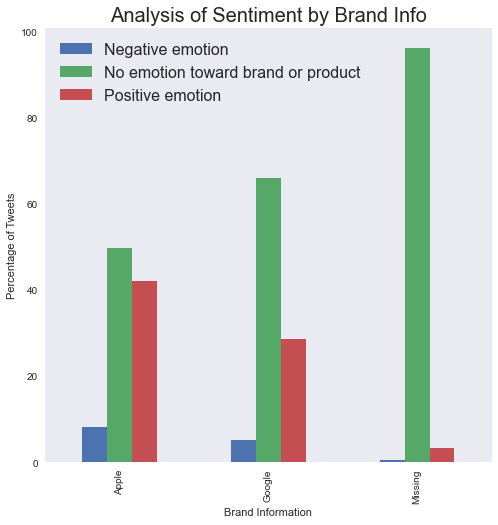

In [538]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(8,8))
concat_df.groupby("imputed_brand")["is_there_an_emotion_directed_at_a_brand_or_product"].value_counts(\
                normalize=True).unstack().plot(kind="bar", ax=ax, grid=False)
ax.set_yticks([0, .20, .40, .60, .80, 1.00])
ax.set_yticklabels([0, 20, 40, 60, 80, 100])
ax.set_ylabel("Percentage of Tweets")
ax.set_xlabel("Brand Information")
ax.legend(bbox_to_anchor=(.5, .87))
ax.set_title("Analysis of Sentiment by Brand Info", fontsize=20)
plt.legend(fontsize=16);

- Google |  1928 No Emotion, 838 Positive Emotion,  153 Negative Emotion | 5.48 to 1 Positive to Negative
- Apple  |  2492 No Emotion, 2107 Positive Emotion, 412 Negative Emotion | 5.11 to 1 Positive to Negative

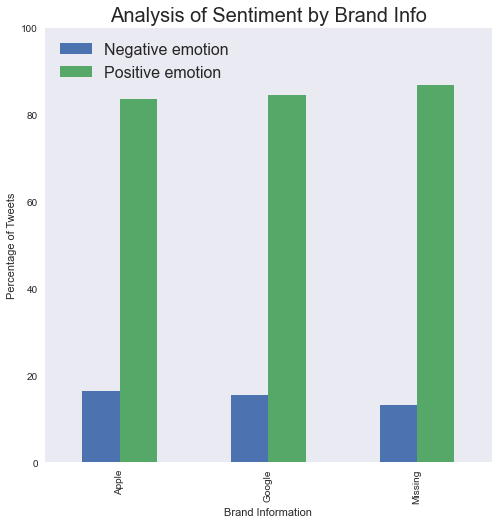

In [554]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(8,8))
binary_df.groupby("imputed_brand")["is_there_an_emotion_directed_at_a_brand_or_product"].value_counts(\
                normalize=True).unstack().plot(kind="bar", ax=ax, grid=False)
ax.set_yticks([0, .20, .40, .60, .80, 1.00])
ax.set_yticklabels([0, 20, 40, 60, 80, 100])
ax.set_ylabel("Percentage of Tweets")
ax.set_xlabel("Brand Information")
ax.legend(bbox_to_anchor=(.5, .87))
ax.set_title("Analysis of Sentiment by Brand Info", fontsize=20)
plt.legend(fontsize=16);

In [555]:
binary_df["is_there_an_emotion_directed_at_a_brand_or_product"].value_counts()

Positive emotion    2978
Negative emotion     570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [556]:
binary_df[binary_df['imputed_brand'] == "Apple"]["is_there_an_emotion_directed_at_a_brand_or_product"].value_counts()

Positive emotion    2107
Negative emotion     412
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [557]:
binary_df[binary_df['imputed_brand'] == "Google"]["is_there_an_emotion_directed_at_a_brand_or_product"].value_counts()

Positive emotion    838
Negative emotion    153
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

# Problem Description

Our task is to identify whether or not tweets have positive or negative emotions. From the assignment:

"There are many approaches to NLP problems - start with something simple and iterate from there. For example, you could start by limiting your analysis to positive and negative Tweets only, allowing you to build a binary classifier. Then you could add in the neutral Tweets to build out a multiclass classifier. You may also consider using some of the more advanced NLP methods in the Mod 4 Appendix."

### Creating a binary dataframe: only positive or negative

In [80]:
concat_df.target.value_counts()

0.0    5388
2.0    2978
1.0     570
Name: target, dtype: int64

In [81]:
binary_df = concat_df.loc[concat_df.target != 0].copy()

In [82]:
concat_df.shape, df.shape

((8936, 10), (8936, 7))

### Binary values of positive or negative only

In [83]:
binary_df.shape

(3548, 10)

In [84]:
binary_df.head(2)

,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,tweet_clean,target,imputed_brand
0,1.0,0.0,0.0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,I have a 3G iPhone After 3 hrs tweeting at RIS...,1.0,Apple
1,1.0,0.0,0.0,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,Know about Awesome iPad iPhone app that you ll...,2.0,Apple


In [85]:
binary_df.target.value_counts(normalize=True)

2.0    0.839346
1.0    0.160654
Name: target, dtype: float64

We have a ratio of more or less 5 - to - 1 Positive to negative. I will re-map the values of the target column so that "0" is a positive review, and "1" is a negative review.

### Modifying the column so values are 0 and 1, positive and negative respectively

In [86]:
binary_df['target'] = binary_df['target'].apply(lambda x: 0 if x == 2 else x)

#### Sanity Check

In [87]:
binary_df['target'].value_counts()

0.0    2978
1.0     570
Name: target, dtype: int64

### Preprocessing

Now that a binary column of 0's and 1's is in place, I will begin the process of preparing the tweets as tokens with the correct lemmatization, case, and removal of stop words. 

#### Re-examination of the df

In [88]:
binary_df.head(2)

,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,tweet_clean,target,imputed_brand
0,1.0,0.0,0.0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,I have a 3G iPhone After 3 hrs tweeting at RIS...,1.0,Apple
1,1.0,0.0,0.0,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,Know about Awesome iPad iPhone app that you ll...,0.0,Apple


### Creating a function to handle all of the preprocessing tasks, borrowing from lecture material

In [89]:
### get_wordnet_pos was taken from Lecture 51-nlp_modeling.ipynb 
### link to the lecture: https://github.com/dvdhartsman/NTL-DS-080723/blob/main/4phase/51-nlp_modeling.ipynb


def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


### This is the function that will be applied to the dataframe

In [90]:
def preprocess(tweet):
    """
    This is a function that is intended to handle all of the tokenization, lemmatization, and other
    preprocessing for our tweet data. It will make use of objects from other libraries, and will return
    a complete list of tokens that are ready to be vectorized into numerical data.
    """
    
    # Create a list of stopwords to be removed from our tokenized word list
    stops = stopwords.words("english")
    # Add punctuation to the list of stopwords
    stops += string.punctuation
    # Providing a regex pattern for the tokenizer to handle
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    # Instantiating a tokenizer
    tokenizer = RegexpTokenizer(pattern)
    # Creating a list of raw tokens
    raw_tokens = tokenizer.tokenize(tweet)
    # Using a comprehension to lower case every token
    lower_tokens = [i.lower() for i in raw_tokens]
    # Remove the stopwords from the list of tokens
    stopped_words = [i for i in lower_tokens if i not in stops]
    
    # Adding parts of speech to prepare for Lemmatization
    
    # This is the initial method to get parts of speech
    stopped_words = pos_tag(stopped_words)
    
    # Get_wordnet_pos() is the function to modify the pos definitions/assignments, creates tuples of (<word>, <pos>)
    stopped_words = [(word[0], get_wordnet_pos(word[1])) for word in stopped_words]
    
    lemmatizer = WordNetLemmatizer() 
    
    # This corrects the parts of speech and maximizes the usefulness of the lemmatization!!!!!
    document = [lemmatizer.lemmatize(word[0], word[1]) for word in stopped_words]
    
    # Re-join the list of cleaned tokens
    cleaned_doc = " ".join(document)
    return cleaned_doc
    

# Defining a class to track the model iterations

In [230]:
len(sns.color_palette("rocket"))

6

### Initially created for multi-class classification

In [250]:
# Creating the class that will store my data 

class Model():
    model_list = []
    model_df = pd.DataFrame(columns=['name','train_accuracy','train_prec','train_recall','train_f1','train_logloss',\
                                     'test_accuracy','test_prec','test_recall','test_f1','test_logloss', "AUC"])
    
    def __init__(self, name, model, vectorizer, X_train, X_test, y_train, y_test):
        self.name = name
        self.model = model
        self.vectorizer = vectorizer
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        # Collection of training attributes
        # f1, recall, precision add "_macro" for multi-class
        self.train_results = cross_validate(self.model, self.X_train, self.y_train, scoring=[
            'precision', 'accuracy', 'recall', 'f1', 'neg_log_loss'], n_jobs=4, verbose=1)
        # Train metrics
        self.train_acc = np.mean(self.train_results['test_accuracy'])
        self.train_prec = np.mean(self.train_results['test_precision']) # add "_macro" for multi-class
        self.train_rec = np.mean(self.train_results['test_recall'])  # add "_macro" for multi-class
        self.train_f1 = np.mean(self.train_results['test_f1'])  # add "_macro" for multi-class
        self.train_logloss = -np.mean(self.train_results['test_neg_log_loss'])
        
        # Test metrics
        self.y_pred_proba = self.model.predict_proba(self.X_test)
        self.y_pred = self.model.predict(self.X_test)
        
        self.test_score = model.score(self.X_test, self.y_test)
        # average = "macro" for multi-class
        self.test_recall = recall_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        # average = "macro" for multi-class
        self.test_prec = precision_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        self.test_log_loss = log_loss(self.y_test, self.y_pred_proba)
        # average = "macro" for multi-class
        self.test_f1 = f1_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        
        # AUC metrics -> Remove when we get to multi-class
        self.auc = roc_auc_score(self.y_test, self.y_pred_proba[:,1])
        
        # Add model object to the class data container for access within the notebook
        Model.model_list.append(self)
        
        # Dictionary containing all of the metrics to add to the dataframe
        self.attributes = {'name':self.name, 'train_accuracy':self.train_acc, "train_prec": self.train_prec,
                           "train_recall": self.train_rec, "train_f1": self.train_f1, \
                           "train_logloss": self.train_logloss, \
                          'test_accuracy':self.test_score, "test_prec": self.test_prec,
                           "test_recall": self.test_recall, "test_f1": self.test_f1, \
                           "test_logloss": self.test_log_loss, "AUC":self.auc}
        
        # Add the metrics to the class dataframe
        Model.model_df.loc[len(Model.model_df)] = self.attributes
        
        
        # Confusion Matrix Plot -> currently in init method
        fig, ax = plt.subplots(figsize=(7,7))
        self.cm = ConfusionMatrixDisplay.from_estimator(\
                                self.model, X=self.X_test, y=self.y_test, ax=ax)
        plt.title("Confusion Matrix for Test Data");
        
    # Roc Curve plot method -> needs to be removed for multi-class
    def roc_curve(self):
        # Create the plot
        fig, ax = plt.subplots(figsize=(7,7))
        # get the predict_proba values
        y_hat_hd = self.y_pred_proba[:, 1]

        # Get the FPR and TPR data
        fpr, tpr, thresholds = roc_curve(y_test, y_hat_hd)
        # Plot the actual graph
        ax.plot(fpr, tpr)
        ax.set_title(f"{self.name} ROC Curve");
        
    def compare_roc_curve(self):
        # Color Palette
        colors = sns.color_palette("Paired", n_colors=20)
        # Create the plot
        fig, ax = plt.subplots(figsize=(10,10))
        for i in range(len(Model.model_list)):
            # get the predict_proba values
            y_hat_hd = Model.model_list[i].y_pred_proba[:, 1]

            # Get the FPR and TPR data
            fpr, tpr, thresholds = roc_curve(Model.model_list[i].y_test, y_hat_hd)
            # Plot the actual graph
            ax.plot(fpr, tpr, color=colors[i], label=f'{Model.model_list[i].name} | AUC: {Model.model_list[i].auc:.2f})')
        
        ax.set_title(f"Comparison of ROC Curve")
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right');
    
    def confusion_matrix(self):
        # Confusion Matrix Plot -> currently in init method
        fig, ax = plt.subplots(figsize=(7,7))
        self.cm = ConfusionMatrixDisplay.from_estimator(\
                                self.model, X=self.X_test, y=self.y_test, ax=ax)
        plt.title("Confusion Matrix for Test Data");
    
    
    def __repr__(self):
      return f"Model name: ({self.model})"
    
    
    @classmethod
    def get_model_list(cls):
        return cls.model_list

In [92]:
binary_df.columns

Index(['imputed_brand_Apple', 'imputed_brand_Google', 'imputed_brand_Missing',
       'tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product', 'brand',
       'tweet_clean', 'target', 'imputed_brand'],
      dtype='object')

# This is the full preprocessing of the tweet-strings

This part of the preprocessing makes use of functions defined above. Preprocessing standardizes case, removes punctuation and stopwords, and lemmatizes the tokens using the correct parts of speech.

In [205]:
len(sns.color_palette(palette='gist_rainbow'))

6

### Converting the original tweets into a new column

In [94]:
binary_df['tokens'] = binary_df['tweet_text'].apply(preprocess)

### Examination of how the tweets have been converted

In [95]:
binary_df['tokens'][0]

'wesley g iphone hr tweet rise austin dead need upgrade plugin station sxsw'

In [96]:
binary_df['tweet_text'][0]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

In [97]:
# 1 is a negative experience
binary_df['target'][0]

1.0

# Vectorization of the data

In previous exercises, we have used the raw, un-edited text to represent our X variable and the label to represent our y variable. In this case, that would make "binary_df['tweet_text']" our X, and "binary_df['target']" our y. I am inclined to use the imputed brands and the joined string of tokens as our X variable, and the labels as our y.

In [98]:
for i in binary_df.columns:
    print(i)

imputed_brand_Apple
imputed_brand_Google
imputed_brand_Missing
tweet_text
emotion_in_tweet_is_directed_at
is_there_an_emotion_directed_at_a_brand_or_product
brand
tweet_clean
target
imputed_brand
tokens


In [99]:
# Assign the proper values to our X and y variables
X = binary_df[['tokens', 'imputed_brand_Apple', 'imputed_brand_Google', 'imputed_brand_Missing']]
y = binary_df['target']

### Only features currently are the text and the brand

In [102]:
X.head(2)

,tokens,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing
0,wesley g iphone hr tweet rise austin dead need...,1.0,0.0,0.0
1,jessedee know fludapp awesome ipad iphone app ...,1.0,0.0,0.0


In [103]:
y[:2]

0    1.0
1    0.0
Name: target, dtype: float64

### Train/Test Split on the Data

We are performing a train/test split on our data prior to the vectorization of tokens. This is a step taken in order to prevent data leakage. We will also set "stratify=y" due to the imbalanced nature of the data. 

In [104]:
# Train test split on the data, stratifying because of the relative imbalance of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [105]:
X_train.head(2)

,tokens,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing
6087,rt mention join link start tonight person frie...,1.0,0.0,0.0
4758,head free google sponsor happy hour semantic w...,0.0,1.0,0.0


In [106]:
print(X_train["tokens"].shape)
print(X_train.shape)
print(X_train.columns)

(2661,)
(2661, 4)
Index(['tokens', 'imputed_brand_Apple', 'imputed_brand_Google',
       'imputed_brand_Missing'],
      dtype='object')


### Vectorizers: Count Vectorizer | TF-IDF Vectorizer

We will be using two different forms of vectorization: Count Vectorization, and TF-IDF Vectorization. We will use both transformations to see which performs better at predicting tweet sentiment. 

In [107]:
# TF-IDF vectorizer
tfidf = TfidfVectorizer()
Xt_tfidf = tfidf.fit_transform(X_train['tokens'])

### Visual Inspection of the TF-IDF data

In [108]:
# Cell takes a couple minutes to run
df_tfidf = pd.DataFrame(Xt_tfidf.toarray(), columns=tfidf.get_feature_names_out())
df_tfidf.head(2)

,aapl,abacus,abandon,aber,ability,able,abroad,absolute,absolutely,abt,...,zazzle,zazzlesxsw,zazzlsxsw,zero,zip,zite,zombie,zomg,zoom,zzzs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
df_tfidf.shape, X_train.shape

((2661, 4180), (2661, 4))

# Functions to assist in re-combining vectorized text

These functions are intended to make it easier to produce new dataframes with the vectorized text data.

In [112]:
# Will vectorize tokenized data, and recombine it with our original X_train/test
def combine_train_vectorization(X, column, vectorizer):
    vector = vectorizer.fit_transform(X[column])
    vector_df = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out())
    return pd.concat([X.drop(columns=column).reset_index(drop=True), vector_df.reset_index(drop=True)], axis=1)

def combine_test_vectorization(X, column, vectorizer):
    vector = vectorizer.transform(X[column])
    vector_df = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out())
    return pd.concat([X.drop(columns=column).reset_index(drop=True), vector_df.reset_index(drop=True)], axis=1)

In [113]:
# TF-IDF Vectorized Version of the X_train DataFrame
X_train_transformed = combine_train_vectorization(X_train, "tokens", tfidf)

### General Sanity Check

In [115]:
X_train_transformed.head(2)

,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,aapl,abacus,abandon,aber,ability,able,abroad,...,zazzle,zazzlesxsw,zazzlsxsw,zero,zip,zite,zombie,zomg,zoom,zzzs
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
X_train_transformed.shape

(2661, 4183)

In [103]:
X_train_transformed.iloc[0].idxmax()

'imputed_brand_Apple'

In [104]:
X_train_transformed.iloc[0].argmax()

0

In [105]:
X_train_transformed.columns[0]

'imputed_brand_Apple'

### Conducting the same transformation for X_test

In [117]:
X_test.shape

(887, 4)

In [118]:
# Transformation of the X_test DataFrame
X_test_transformed = combine_test_vectorization(X_test, "tokens", tfidf)
X_test_transformed.shape

(887, 4183)

In [119]:
X_train_transformed.head(2)

,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,aapl,abacus,abandon,aber,ability,able,abroad,...,zazzle,zazzlesxsw,zazzlsxsw,zero,zip,zite,zombie,zomg,zoom,zzzs
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


X_train_transformed and X_test_transformed have the same number of rows as they did prior to vectorization, however they both now have 4183 feature columns, most of which are zero values.

# First Dummy Model

This is the creation of our first dummy model. By guessing the most frequent value, the dummy classifier will correctly predict the label 83.9% of the time, consistent with the distribution of labels in our training set. 

In [120]:
dummy = DummyClassifier(strategy="most_frequent")

In [121]:
dummy.fit(X_train_transformed, y_train)

DummyClassifier(strategy='most_frequent')

In [122]:
dummy.score(X_train_transformed, y_train)

0.8391582111987974

In [123]:
y_train.value_counts(normalize=True)

0.0    0.839158
1.0    0.160842
Name: target, dtype: float64

In [128]:
# Score on the test data corresponds to the value counts of the test data
dummy.score(X_test_transformed, y_test)

0.8399098083427283

In [129]:
y_test.value_counts(normalize=True)

0.0    0.83991
1.0    0.16009
Name: target, dtype: float64

Again, the same is true for our test data. By choosing the class that occurs most frequently, our dummy classifier was correct at the exact frequency as the true distribution of our data. 

### Confusion Matrix: Dummy Model -> new method in new sklearn version

In [132]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

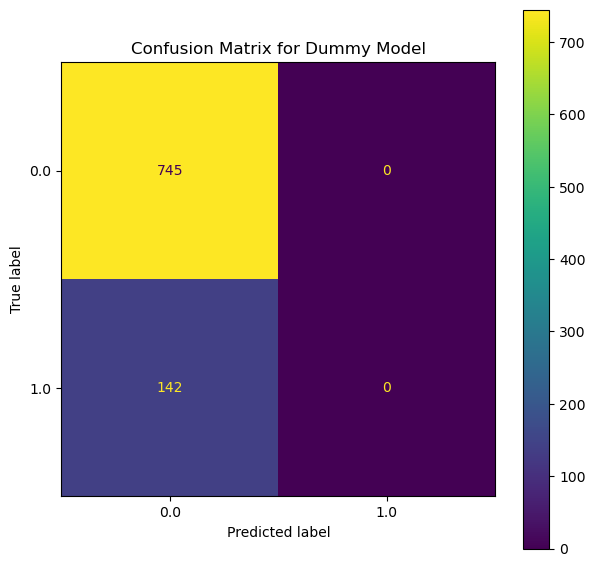

In [139]:
plt.style.use("default")
fig, ax = plt.subplots(figsize=(7,7))
ConfusionMatrixDisplay.from_estimator(dummy, dummy.predict(X_test_transformed), y_test, ax=ax)
ax.set_title("Confusion Matrix for Dummy Model");

### Object Instantiation

We are instantiating the first model object in order to facilitate easier tracking of our model performances across iterations. 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.4s finished


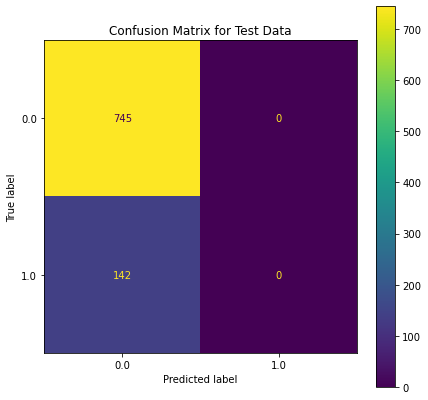

In [251]:
dummy_0 = Model("Dummy", dummy, tfidf, X_train_transformed, X_test_transformed, y_train, y_test)

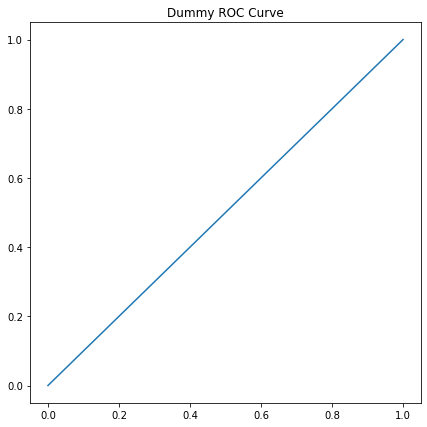

In [216]:
dummy_0.roc_curve()

In [238]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.0,0.0,0.0,5.797319,0.83991,0.0,0.0,0.0,5.770235,0.5


### FSM Naive Bayes creation

In [143]:
mnb = MultinomialNB()

In [144]:
mnb.fit(X_train_transformed, y_train)

MultinomialNB()

### Visual Inspection of Different Model Metrics

In [145]:
# Scores on training data
mnb.score(X_train_transformed, y_train)

0.8489289740698985

In [147]:
# Test the predictions on test data
y_preds = mnb.predict(X_test_transformed)
accuracy_score(y_test, y_preds)

0.8399098083427283

In [148]:
cross_validate(mnb, Xt_tfidf, y_train, scoring=[
            'precision', 'accuracy', 'recall', 'f1', 'neg_log_loss'], n_jobs=4, verbose=1)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


{'fit_time': array([0.0034349 , 0.00348711, 0.00701189, 0.00554228, 0.00457072]),
 'score_time': array([0.01361299, 0.0260458 , 0.020612  , 0.0206368 , 0.01503015]),
 'test_precision': array([1., 1., 1., 1., 1.]),
 'test_accuracy': array([0.84615385, 0.84962406, 0.84398496, 0.84398496, 0.84586466]),
 'test_recall': array([0.04651163, 0.05882353, 0.02352941, 0.03488372, 0.04651163]),
 'test_f1': array([0.08888889, 0.11111111, 0.04597701, 0.06741573, 0.08888889]),
 'test_neg_log_loss': array([-0.38521923, -0.3714225 , -0.38615195, -0.38585453, -0.42158848])}

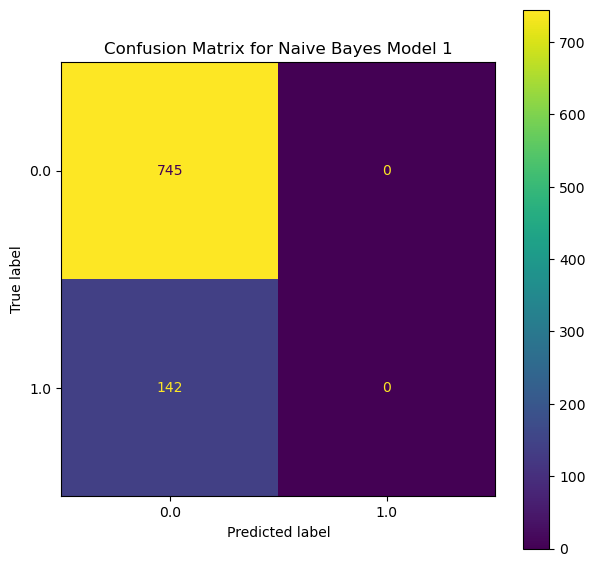

In [149]:
fig, ax = plt.subplots(figsize=(7,7))
ConfusionMatrixDisplay.from_estimator(mnb, X=X_test_transformed, y=y_test, ax=ax)
ax.set_title("Confusion Matrix for Naive Bayes Model 1");

This baseline model performed identically to our dummy classifier. We will have to attempt to modify our model in order to improve the performance thereof.

### Re-emphasizing that all predictions were for class 0

In [150]:
pd.Series(mnb.predict(X_test_transformed)).value_counts(), "True Values:", "*" * 60, y_test.value_counts()

(0.0    887
 dtype: int64,
 'True Values:',
 '************************************************************',
 0.0    745
 1.0    142
 Name: target, dtype: int64)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.7s finished
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


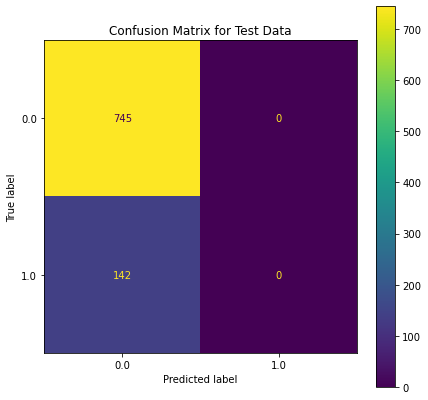

In [252]:
# I am receiving a warning about predictions not summing to 1, but everything seems to be working ok
mnb1 = Model("Naive Bayes 1", mnb, tfidf, X_train_transformed, X_test_transformed, y_train, y_test)

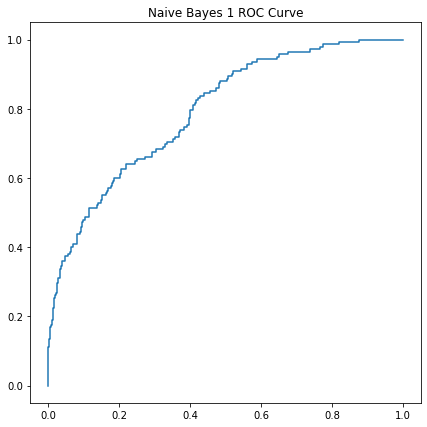

In [219]:
mnb1.roc_curve()

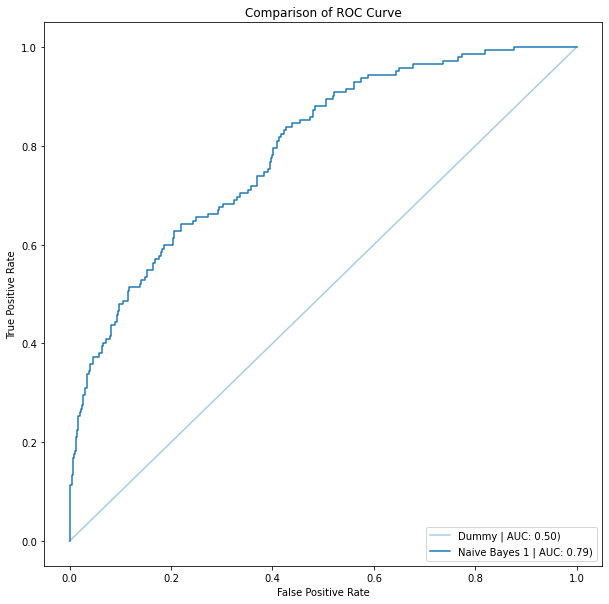

In [253]:
mnb1.compare_roc_curve()

In [241]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.0,0.000000,0.000000,5.797319,0.83991,0.0,0.0,0.0,5.770235,0.500000
1,Naive Bayes 1,0.841413,0.8,0.014036,0.027535,0.450482,0.83991,0.0,0.0,0.0,0.485984,0.792031


### Comparing the TF-IDF Vectorizer with a basic Count Vectorizer

In [130]:
X_train.columns

Index(['tokens', 'imputed_brand_Apple', 'imputed_brand_Google',
       'imputed_brand_Missing'],
      dtype='object')

Here, once again, we make use of the transformation and concatenation functions I defined above. This time, we are using a simple Count Vectorizer transformation.

In [155]:
# Count Vectorizer
count_v = CountVectorizer()
Xt_count = combine_train_vectorization(X_train, "tokens", count_v)
X_test_count = combine_test_vectorization(X_test, 'tokens', count_v)

### Sanity Check

In [156]:
Xt_count.head(2)

,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,aapl,abacus,abandon,aber,ability,able,abroad,...,zazzle,zazzlesxsw,zazzlsxsw,zero,zip,zite,zombie,zomg,zoom,zzzs
0,1.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,1.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [157]:
X_test_count.head(2)

,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,aapl,abacus,abandon,aber,ability,able,abroad,...,zazzle,zazzlesxsw,zazzlsxsw,zero,zip,zite,zombie,zomg,zoom,zzzs
0,1.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model Instantiation

In [159]:
mnb_count = MultinomialNB()
mnb_count.fit(Xt_count, y_train)

MultinomialNB()

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.8s finished
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


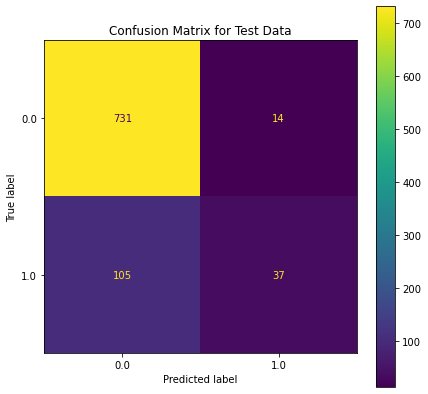

In [254]:
mnb_count1 = Model("MNB Count Vect", mnb_count, count_v, Xt_count, X_test_count, y_train, y_test)

In [255]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.83991,0.00000,0.000000,0.00000,5.770235,0.500000
1,Naive Bayes 1,0.841413,0.800000,0.014036,0.027535,0.450482,0.83991,0.00000,0.000000,0.00000,0.485984,0.792031
2,MNB Count Vect,0.847051,0.540955,0.334172,0.411992,0.522335,0.86584,0.72549,0.260563,0.38342,0.569251,0.819283


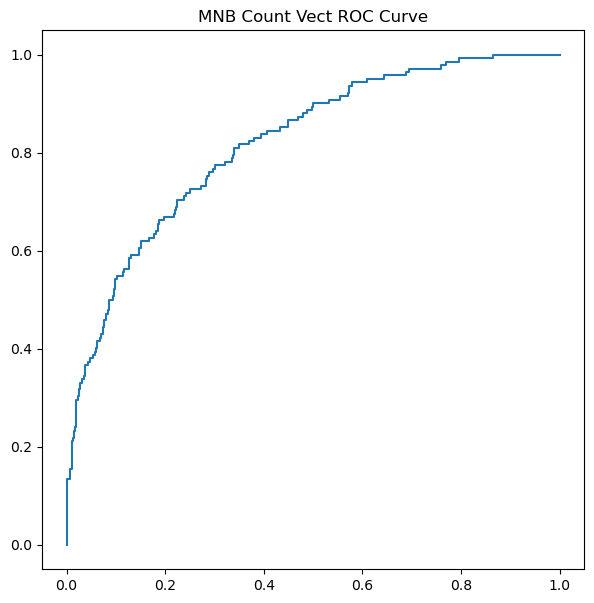

In [162]:
mnb_count1.roc_curve()

Some ver

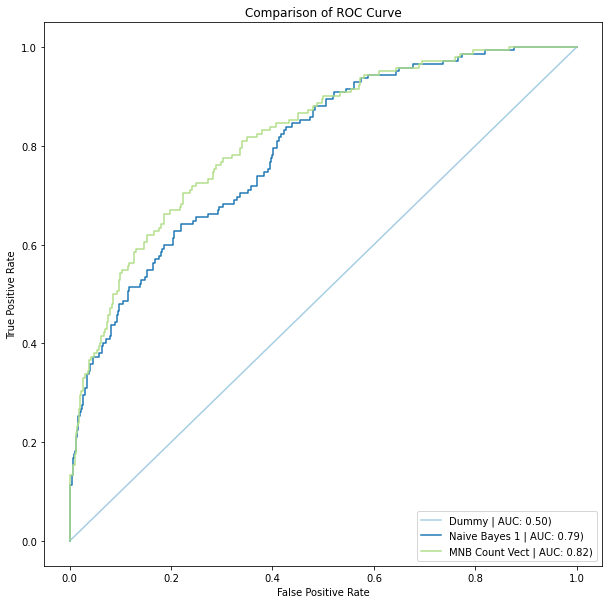

In [256]:
mnb1.compare_roc_curve()

# Further Model Iteration

# Reminder of Variables That Have Been Created:
- X_train_transformed, X_test_transformed - both TF-IDF vectorizations, "tfidf" transformer
- Xt_count, X_test_count - both Count Vectorizer transformations, "count_v" transformer
- y_train/y_test still totally valid

At the end of one day of modeling, so far we have defined a class, defined several functions, and treated our data with the several preprocessing techniques. The features that we are analyzing so far are only the tokenized lemmatized tweets and whether or not that tweet pertained to a specific brand. Tomorrow, I will follow up on different types of models, and will likely move into muti-class classification.

In [245]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.83991,0.00000,0.000000,0.00000,5.770235,0.500000
1,Naive Bayes 1,0.841413,0.800000,0.014036,0.027535,0.450482,0.83991,0.00000,0.000000,0.00000,0.485984,0.792031
2,MNB Count Vect,0.847051,0.540955,0.334172,0.411992,0.522335,0.86584,0.72549,0.260563,0.38342,0.569251,0.819283


In [165]:
# # Verifying the method/function
# because it works, it needs not be run

# colors = sns.color_palette(palette='gist_rainbow')
# fig, ax = plt.subplots(figsize=(10,10))
# for i in range(len(Model.model_list)):
#     # get the predict_proba values
#     y_hat_hd = Model.model_list[i].y_pred_proba[:, 1]

#     # Get the FPR and TPR data
#     fpr, tpr, thresholds = roc_curve(Model.model_list[i].y_test, y_hat_hd)
#     # Plot the actual graph
#     ax.plot(fpr, tpr, color=colors[i], label=f'{Model.model_list[i].name} | AUC: {Model.model_list[i].auc:.2f})')

# ax.set_title(f"Comparison of ROC Curve")
# ax.set_xlabel('False Positive Rate')
# ax.set_ylabel('True Positive Rate')
# ax.legend(loc='lower right');

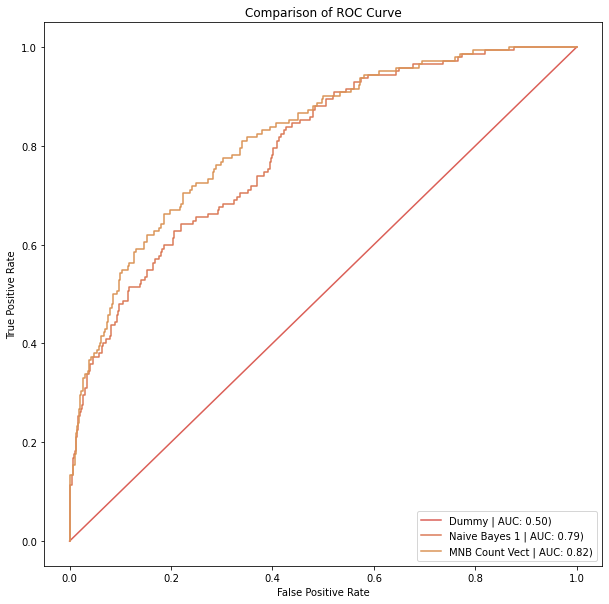

In [246]:
mnb1.compare_roc_curve()

### Random Forest with TF-IDF and CountVect

In [184]:
# TF-IDF vectorization first
from sklearn.ensemble import RandomForestClassifier

rndm_tfidf = RandomForestClassifier(max_depth=4,random_state=42)
rndm_tfidf.fit(X_train_transformed, y_train)

RandomForestClassifier(max_depth=4, random_state=42)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished


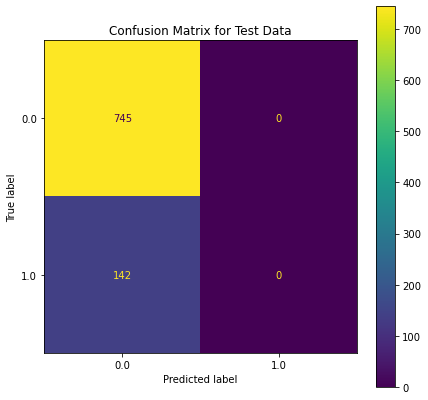

In [257]:
random1 = Model("RF tfidf", rndm_tfidf, tfidf, X_train_transformed, X_test_transformed, y_train, y_test)

In [258]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.83991,0.00000,0.000000,0.00000,5.770235,0.500000
1,Naive Bayes 1,0.841413,0.800000,0.014036,0.027535,0.450482,0.83991,0.00000,0.000000,0.00000,0.485984,0.792031
2,MNB Count Vect,0.847051,0.540955,0.334172,0.411992,0.522335,0.86584,0.72549,0.260563,0.38342,0.569251,0.819283
3,RF tfidf,0.839158,0.000000,0.000000,0.000000,0.425232,0.83991,0.00000,0.000000,0.00000,0.423115,0.762378


Horrible results from the first random forest classifier.

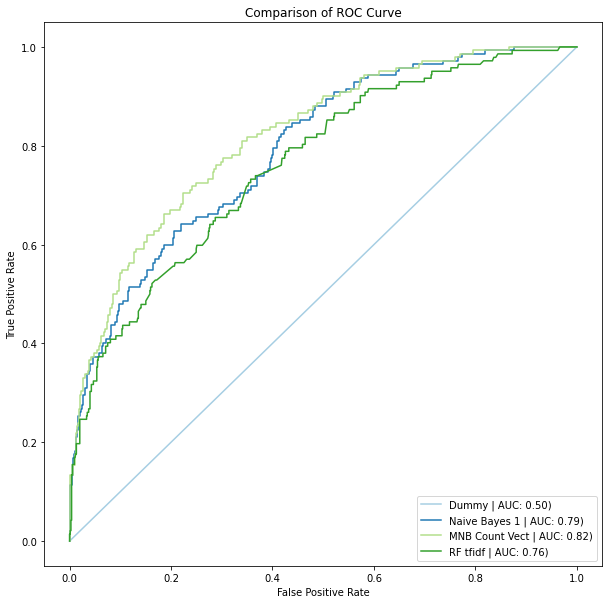

In [259]:
random1.compare_roc_curve()

### Count Vectorizer Random Forest

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished


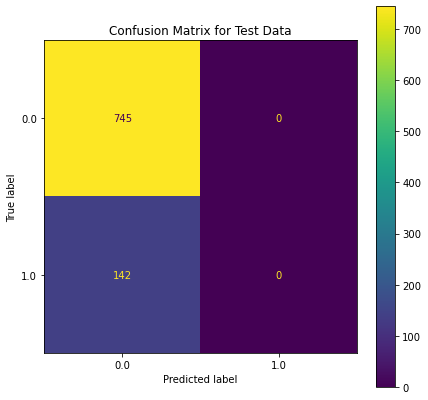

In [260]:
rndm_count = RandomForestClassifier(max_depth=4,random_state=42)
rndm_count.fit(X_train_transformed, y_train)
random2 = Model("RF count", rndm_count, count_v, Xt_count, X_test_count, y_train, y_test)

In [261]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.83991,0.00000,0.000000,0.00000,5.770235,0.500000
1,Naive Bayes 1,0.841413,0.800000,0.014036,0.027535,0.450482,0.83991,0.00000,0.000000,0.00000,0.485984,0.792031
2,MNB Count Vect,0.847051,0.540955,0.334172,0.411992,0.522335,0.86584,0.72549,0.260563,0.38342,0.569251,0.819283
3,RF tfidf,0.839158,0.000000,0.000000,0.000000,0.425232,0.83991,0.00000,0.000000,0.00000,0.423115,0.762378
4,RF count,0.839158,0.000000,0.000000,0.000000,0.425335,0.83991,0.00000,0.000000,0.00000,0.423232,0.746966


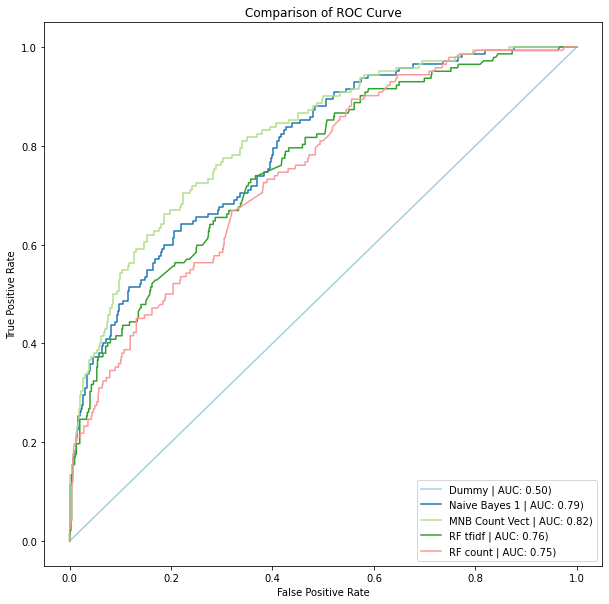

In [262]:
random2.compare_roc_curve()

Still very poor results relative to the MNB classifier at the moment. We Will check out a few other models yet.

### AdaBoost with tfidf/count

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   16.6s finished


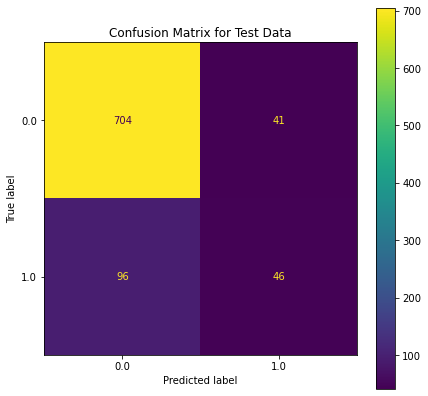

In [263]:
ada_tfidf = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_tfidf.fit(X_train_transformed, y_train)
ada1 = Model("Ada tfidf", ada_tfidf, tfidf, X_train_transformed, X_test_transformed, y_train, y_test)

In [264]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.839910,0.000000,0.000000,0.000000,5.770235,0.500000
1,Naive Bayes 1,0.841413,0.800000,0.014036,0.027535,0.450482,0.839910,0.000000,0.000000,0.000000,0.485984,0.792031
2,MNB Count Vect,0.847051,0.540955,0.334172,0.411992,0.522335,0.865840,0.725490,0.260563,0.383420,0.569251,0.819283
3,RF tfidf,0.839158,0.000000,0.000000,0.000000,0.425232,0.839910,0.000000,0.000000,0.000000,0.423115,0.762378
4,RF count,0.839158,0.000000,0.000000,0.000000,0.425335,0.839910,0.000000,0.000000,0.000000,0.423232,0.746966
5,Ada tfidf,0.852682,0.580502,0.301560,0.395751,0.644153,0.845547,0.528736,0.323944,0.401747,0.651335,0.757397


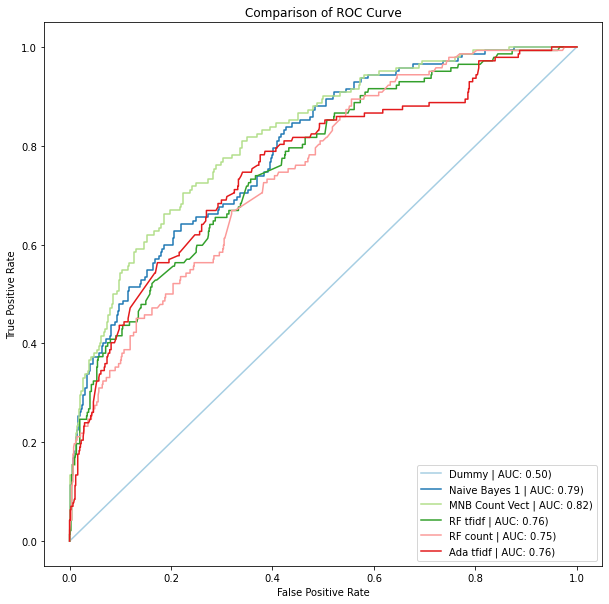

In [265]:
ada1.compare_roc_curve()

### Ada has the highest test F1, but other metrics still favor MNB with count vectorization

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   15.6s finished


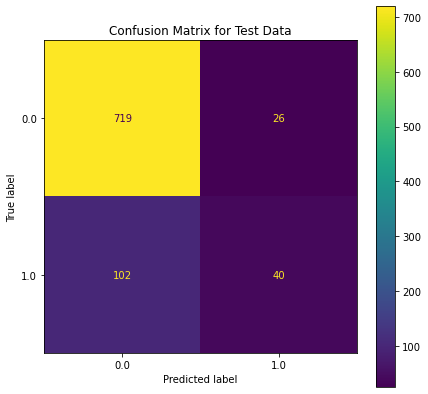

In [266]:
ada_count = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_count.fit(Xt_count, y_train)
ada2 = Model("Ada count", ada_count, tfidf, Xt_count, X_test_count, y_train, y_test)

In [267]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.839910,0.000000,0.000000,0.000000,5.770235,0.500000
1,Naive Bayes 1,0.841413,0.800000,0.014036,0.027535,0.450482,0.839910,0.000000,0.000000,0.000000,0.485984,0.792031
2,MNB Count Vect,0.847051,0.540955,0.334172,0.411992,0.522335,0.865840,0.725490,0.260563,0.383420,0.569251,0.819283
3,RF tfidf,0.839158,0.000000,0.000000,0.000000,0.425232,0.839910,0.000000,0.000000,0.000000,0.423115,0.762378
4,RF count,0.839158,0.000000,0.000000,0.000000,0.425335,0.839910,0.000000,0.000000,0.000000,0.423232,0.746966
5,Ada tfidf,0.852682,0.580502,0.301560,0.395751,0.644153,0.845547,0.528736,0.323944,0.401747,0.651335,0.757397
6,Ada count,0.855314,0.608217,0.306265,0.403826,0.651356,0.855693,0.606061,0.281690,0.384615,0.656700,0.778065


Once again, count vectorized data seems to give a better read on the sentiment of the data. Accuracy is still outperforming the dummy, but hasn't improved too significantly.

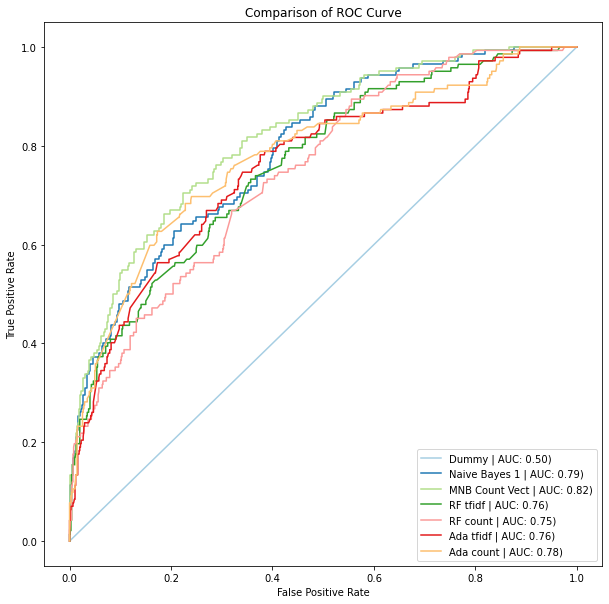

In [268]:
ada2.compare_roc_curve()

In [198]:
print(X_train_transformed.shape)
print(X_test_transformed.shape)

(2661, 4183)
(887, 4183)


### XGBoost classifier

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.3min finished


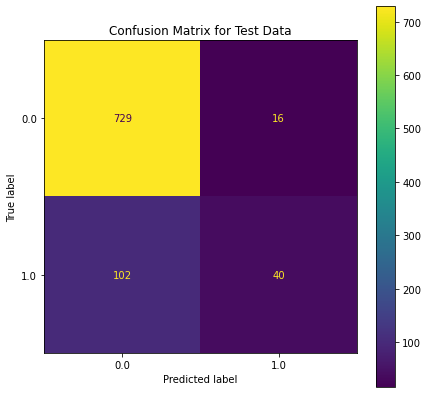

In [269]:
# takes a couple minutes to run
from xgboost import XGBClassifier
x_tfidf = XGBClassifier(random_state=42)
x_tfidf.fit(X_train_transformed, y_train)
x1 = Model("X tfidf", x_tfidf, tfidf, X_train_transformed, X_test_transformed, y_train, y_test)

In [270]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.839910,0.000000,0.000000,0.000000,5.770235,0.500000
1,Naive Bayes 1,0.841413,0.800000,0.014036,0.027535,0.450482,0.839910,0.000000,0.000000,0.000000,0.485984,0.792031
2,MNB Count Vect,0.847051,0.540955,0.334172,0.411992,0.522335,0.865840,0.725490,0.260563,0.383420,0.569251,0.819283
3,RF tfidf,0.839158,0.000000,0.000000,0.000000,0.425232,0.839910,0.000000,0.000000,0.000000,0.423115,0.762378
4,RF count,0.839158,0.000000,0.000000,0.000000,0.425335,0.839910,0.000000,0.000000,0.000000,0.423232,0.746966
5,Ada tfidf,0.852682,0.580502,0.301560,0.395751,0.644153,0.845547,0.528736,0.323944,0.401747,0.651335,0.757397
6,Ada count,0.855314,0.608217,0.306265,0.403826,0.651356,0.855693,0.606061,0.281690,0.384615,0.656700,0.778065
7,X tfidf,0.857946,0.670115,0.245472,0.355644,0.356290,0.866967,0.714286,0.281690,0.404040,0.352597,0.796658


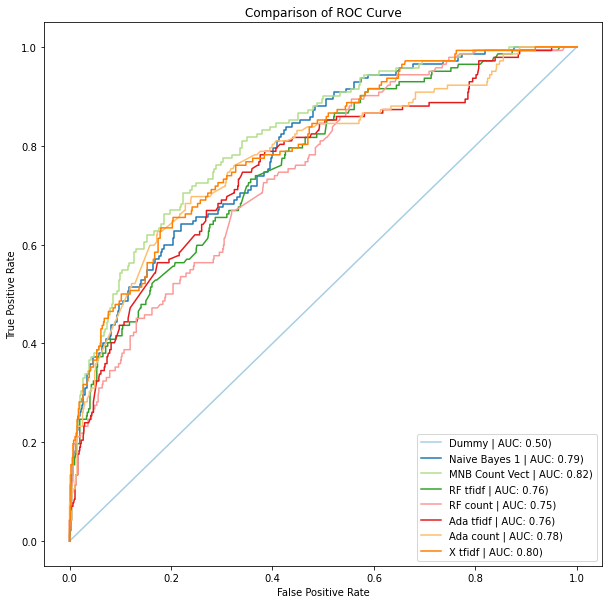

In [271]:
x1.compare_roc_curve()

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.3min finished


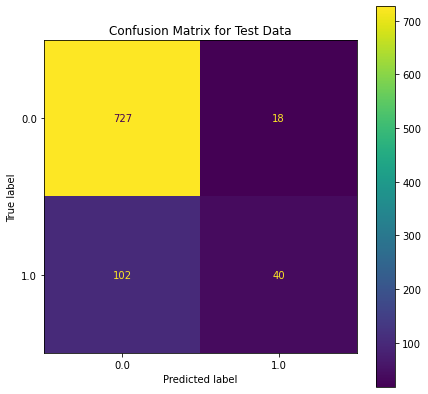

In [272]:
# Count Vectorizer Data
x_count = XGBClassifier(random_state=42)
x_count.fit(Xt_count, y_train)
x2 = Model("X count", x_count, count_v, Xt_count, X_test_count, y_train, y_test)

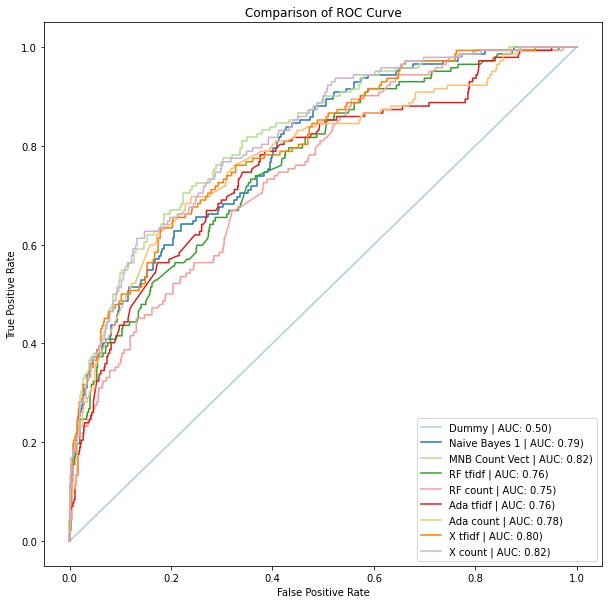

In [275]:
x2.compare_roc_curve()

In [273]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.839910,0.000000,0.000000,0.000000,5.770235,0.500000
1,Naive Bayes 1,0.841413,0.800000,0.014036,0.027535,0.450482,0.839910,0.000000,0.000000,0.000000,0.485984,0.792031
2,MNB Count Vect,0.847051,0.540955,0.334172,0.411992,0.522335,0.865840,0.725490,0.260563,0.383420,0.569251,0.819283
3,RF tfidf,0.839158,0.000000,0.000000,0.000000,0.425232,0.839910,0.000000,0.000000,0.000000,0.423115,0.762378
4,RF count,0.839158,0.000000,0.000000,0.000000,0.425335,0.839910,0.000000,0.000000,0.000000,0.423232,0.746966
5,Ada tfidf,0.852682,0.580502,0.301560,0.395751,0.644153,0.845547,0.528736,0.323944,0.401747,0.651335,0.757397
6,Ada count,0.855314,0.608217,0.306265,0.403826,0.651356,0.855693,0.606061,0.281690,0.384615,0.656700,0.778065
7,X tfidf,0.857946,0.670115,0.245472,0.355644,0.356290,0.866967,0.714286,0.281690,0.404040,0.352597,0.796658
8,X count,0.863960,0.719101,0.261888,0.380519,0.336920,0.864713,0.689655,0.281690,0.400000,0.337870,0.816396


For the first time in our initial iterations, the XGBoost model performed better with tf-idf vectorization. Right now, our top two performing models on balance are:
- MNB Count Vect
- X tfidf

Both models have the best AUC's for their respective roc curves, and have the best balance of precision and recall. While the AdaBoosted model also performed well, its underperformance across the rest of the metrics is concerning.

### Smote Synthetic Sampling

We will attempt to combat the class imbalance by using synthetic resampling provided by the imblearn library's SMOTE object. This will, once again, create new data objects which do not require visual inspection, however it will be one more set of variables to keep track of. 

In [178]:
# TF-IDF vector first
sm = SMOTE(random_state=42)
X_res_tfidf, y_res = sm.fit_resample(X_train_transformed, y_train)

In [277]:
# TF-IDF vector first
sm = SMOTE(random_state=42)
X_res_count, y_res_count = sm.fit_resample(Xt_count, y_train)

### Inspecting the data

In [274]:
X_res_tfidf.head()

,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,aapl,abacus,abandon,aber,ability,able,abroad,...,zazzle,zazzlesxsw,zazzlsxsw,zero,zip,zite,zombie,zomg,zoom,zzzs
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
X_res_tfidf.shape, X_train_transformed.shape, Xt_count.shape

((4466, 4183), (2661, 4183), (2661, 4183))

In [180]:
y_res.shape, y_train.shape

((4466,), (2661,))

In [278]:
X_res_count.head(2)

,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,aapl,abacus,abandon,aber,ability,able,abroad,...,zazzle,zazzlesxsw,zazzlsxsw,zero,zip,zite,zombie,zomg,zoom,zzzs
0,1.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,1.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# First Model with Smote Transformation

In [276]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.839910,0.000000,0.000000,0.000000,5.770235,0.500000
1,Naive Bayes 1,0.841413,0.800000,0.014036,0.027535,0.450482,0.839910,0.000000,0.000000,0.000000,0.485984,0.792031
2,MNB Count Vect,0.847051,0.540955,0.334172,0.411992,0.522335,0.865840,0.725490,0.260563,0.383420,0.569251,0.819283
3,RF tfidf,0.839158,0.000000,0.000000,0.000000,0.425232,0.839910,0.000000,0.000000,0.000000,0.423115,0.762378
4,RF count,0.839158,0.000000,0.000000,0.000000,0.425335,0.839910,0.000000,0.000000,0.000000,0.423232,0.746966
5,Ada tfidf,0.852682,0.580502,0.301560,0.395751,0.644153,0.845547,0.528736,0.323944,0.401747,0.651335,0.757397
6,Ada count,0.855314,0.608217,0.306265,0.403826,0.651356,0.855693,0.606061,0.281690,0.384615,0.656700,0.778065
7,X tfidf,0.857946,0.670115,0.245472,0.355644,0.356290,0.866967,0.714286,0.281690,0.404040,0.352597,0.796658
8,X count,0.863960,0.719101,0.261888,0.380519,0.336920,0.864713,0.689655,0.281690,0.400000,0.337870,0.816396


### Naive Bayes with Smote

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.8s finished
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.1s finished
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


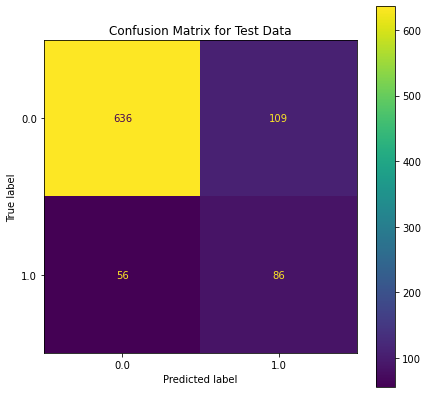

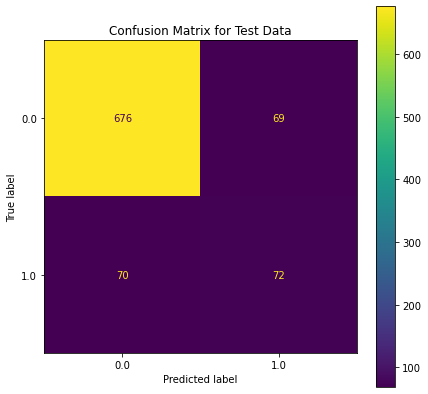

In [279]:
# Naive Bayes with Smote
mnb_smote_tfidf = MultinomialNB()
mnb_smote_count = MultinomialNB()
# Fitting each model with Count/TF-IDF
mnb_smote_tfidf.fit(X_res_tfidf, y_res)
mnb_smote_count.fit(X_res_count, y_res_count)

# Model Object Creation
mnb_S_T = Model("Bayes TF-IDF Smote", mnb_smote_tfidf, tfidf, X_res_tfidf, X_test_transformed, y_res, y_test)
mnb_S_C = Model("Bayes Count Smote", mnb_smote_count, count_v, X_res_count, X_test_count, y_res_count, y_test)

In [280]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.839910,0.000000,0.000000,0.000000,5.770235,0.500000
1,Naive Bayes 1,0.841413,0.800000,0.014036,0.027535,0.450482,0.839910,0.000000,0.000000,0.000000,0.485984,0.792031
2,MNB Count Vect,0.847051,0.540955,0.334172,0.411992,0.522335,0.865840,0.725490,0.260563,0.383420,0.569251,0.819283
3,RF tfidf,0.839158,0.000000,0.000000,0.000000,0.425232,0.839910,0.000000,0.000000,0.000000,0.423115,0.762378
4,RF count,0.839158,0.000000,0.000000,0.000000,0.425335,0.839910,0.000000,0.000000,0.000000,0.423232,0.746966
5,Ada tfidf,0.852682,0.580502,0.301560,0.395751,0.644153,0.845547,0.528736,0.323944,0.401747,0.651335,0.757397
6,Ada count,0.855314,0.608217,0.306265,0.403826,0.651356,0.855693,0.606061,0.281690,0.384615,0.656700,0.778065
7,X tfidf,0.857946,0.670115,0.245472,0.355644,0.356290,0.866967,0.714286,0.281690,0.404040,0.352597,0.796658
8,X count,0.863960,0.719101,0.261888,0.380519,0.336920,0.864713,0.689655,0.281690,0.400000,0.337870,0.816396
9,Bayes TF-IDF Smote,0.911332,0.860428,0.982094,0.917192,0.310649,0.813980,0.441026,0.605634,0.510386,0.420624,0.836752


### Random Forest Classifier

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.9s finished


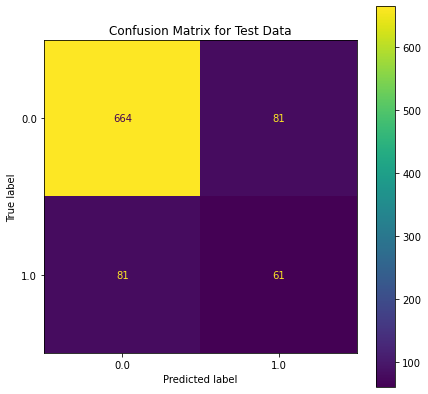

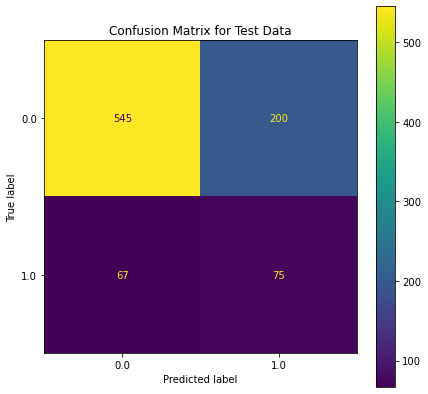

In [281]:
# Random Forest with Smote
RF_smote_tfidf = RandomForestClassifier(max_depth=4,random_state=42)
RF_smote_count = RandomForestClassifier(max_depth=4,random_state=42)
# Fitting each model with Count/TF-IDF
RF_smote_tfidf.fit(X_res_tfidf, y_res)
RF_smote_count.fit(X_res_count, y_res_count)

# Model Object Creation
RF_S_T = Model("R.F. TF-IDF Smote", RF_smote_tfidf, tfidf, X_res_tfidf, X_test_transformed, y_res, y_test)
RF_S_C = Model("R.F. Count Smote", RF_smote_count, count_v, X_res_count, X_test_count, y_res_count, y_test)

In [282]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.839910,0.000000,0.000000,0.000000,5.770235,0.500000
1,Naive Bayes 1,0.841413,0.800000,0.014036,0.027535,0.450482,0.839910,0.000000,0.000000,0.000000,0.485984,0.792031
2,MNB Count Vect,0.847051,0.540955,0.334172,0.411992,0.522335,0.865840,0.725490,0.260563,0.383420,0.569251,0.819283
3,RF tfidf,0.839158,0.000000,0.000000,0.000000,0.425232,0.839910,0.000000,0.000000,0.000000,0.423115,0.762378
4,RF count,0.839158,0.000000,0.000000,0.000000,0.425335,0.839910,0.000000,0.000000,0.000000,0.423232,0.746966
5,Ada tfidf,0.852682,0.580502,0.301560,0.395751,0.644153,0.845547,0.528736,0.323944,0.401747,0.651335,0.757397
6,Ada count,0.855314,0.608217,0.306265,0.403826,0.651356,0.855693,0.606061,0.281690,0.384615,0.656700,0.778065
7,X tfidf,0.857946,0.670115,0.245472,0.355644,0.356290,0.866967,0.714286,0.281690,0.404040,0.352597,0.796658
8,X count,0.863960,0.719101,0.261888,0.380519,0.336920,0.864713,0.689655,0.281690,0.400000,0.337870,0.816396
9,Bayes TF-IDF Smote,0.911332,0.860428,0.982094,0.917192,0.310649,0.813980,0.441026,0.605634,0.510386,0.420624,0.836752


### AdaBoost

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   28.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   27.7s finished


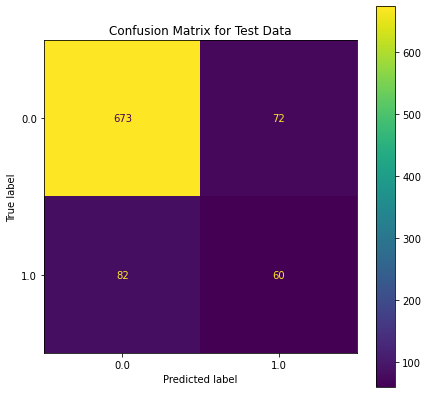

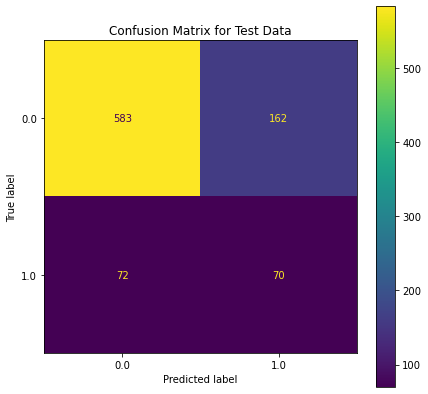

In [284]:
# AdaBoost with Smote
ADA_smote_tfidf = AdaBoostClassifier(n_estimators=100, random_state=42)
ADA_smote_count = AdaBoostClassifier(n_estimators=100, random_state=42)
# Fitting each model with Count/TF-IDF
ADA_smote_tfidf.fit(X_res_tfidf, y_res)
ADA_smote_count.fit(X_res_count, y_res_count)

# Model Object Creation
ADA_S_T = Model("Bayes TF-IDF Smote", ADA_smote_tfidf, tfidf, X_res_tfidf, X_test_transformed, y_res, y_test)
ADA_S_C = Model("Bayes Count Smote", ADA_smote_count, count_v, X_res_count, X_test_count, y_res_count, y_test)

In [287]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.839910,0.000000,0.000000,0.000000,5.770235,0.500000
1,Naive Bayes 1,0.841413,0.800000,0.014036,0.027535,0.450482,0.839910,0.000000,0.000000,0.000000,0.485984,0.792031
2,MNB Count Vect,0.847051,0.540955,0.334172,0.411992,0.522335,0.865840,0.725490,0.260563,0.383420,0.569251,0.819283
3,RF tfidf,0.839158,0.000000,0.000000,0.000000,0.425232,0.839910,0.000000,0.000000,0.000000,0.423115,0.762378
4,RF count,0.839158,0.000000,0.000000,0.000000,0.425335,0.839910,0.000000,0.000000,0.000000,0.423232,0.746966
5,Ada tfidf,0.852682,0.580502,0.301560,0.395751,0.644153,0.845547,0.528736,0.323944,0.401747,0.651335,0.757397
6,Ada count,0.855314,0.608217,0.306265,0.403826,0.651356,0.855693,0.606061,0.281690,0.384615,0.656700,0.778065
7,X tfidf,0.857946,0.670115,0.245472,0.355644,0.356290,0.866967,0.714286,0.281690,0.404040,0.352597,0.796658
8,X count,0.863960,0.719101,0.261888,0.380519,0.336920,0.864713,0.689655,0.281690,0.400000,0.337870,0.816396
9,Bayes TF-IDF Smote,0.911332,0.860428,0.982094,0.917192,0.310649,0.813980,0.441026,0.605634,0.510386,0.420624,0.836752


In [289]:
# correcting a mistake 
Model.model_df.loc[13, 'name'] = "AdaBoost TF-IDF Smote"
Model.model_df.loc[14, 'name'] = "AdaBoost Count Smote"

In [292]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.839910,0.000000,0.000000,0.000000,5.770235,0.500000
1,Naive Bayes 1,0.841413,0.800000,0.014036,0.027535,0.450482,0.839910,0.000000,0.000000,0.000000,0.485984,0.792031
2,MNB Count Vect,0.847051,0.540955,0.334172,0.411992,0.522335,0.865840,0.725490,0.260563,0.383420,0.569251,0.819283
3,RF tfidf,0.839158,0.000000,0.000000,0.000000,0.425232,0.839910,0.000000,0.000000,0.000000,0.423115,0.762378
4,RF count,0.839158,0.000000,0.000000,0.000000,0.425335,0.839910,0.000000,0.000000,0.000000,0.423232,0.746966
5,Ada tfidf,0.852682,0.580502,0.301560,0.395751,0.644153,0.845547,0.528736,0.323944,0.401747,0.651335,0.757397
6,Ada count,0.855314,0.608217,0.306265,0.403826,0.651356,0.855693,0.606061,0.281690,0.384615,0.656700,0.778065
7,X tfidf,0.857946,0.670115,0.245472,0.355644,0.356290,0.866967,0.714286,0.281690,0.404040,0.352597,0.796658
8,X count,0.863960,0.719101,0.261888,0.380519,0.336920,0.864713,0.689655,0.281690,0.400000,0.337870,0.816396
9,Bayes TF-IDF Smote,0.911332,0.860428,0.982094,0.917192,0.310649,0.813980,0.441026,0.605634,0.510386,0.420624,0.836752


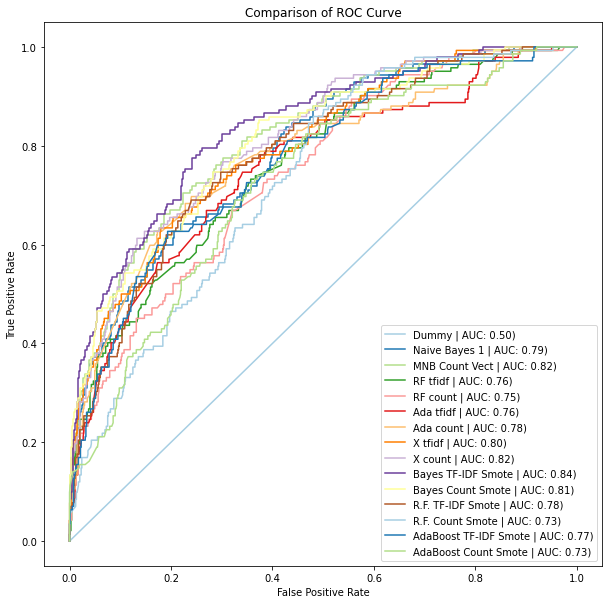

In [291]:
ADA_S_C.compare_roc_curve()

### XGBoost with Smote

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.3min finished


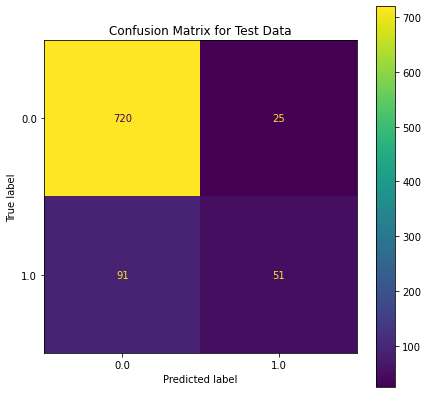

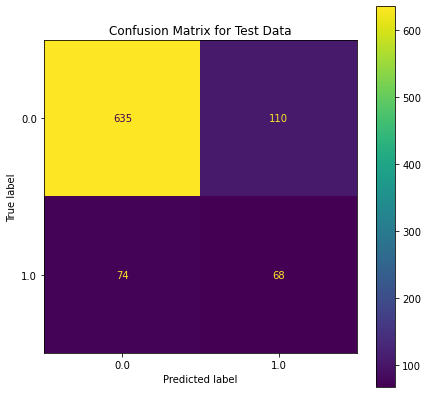

In [293]:
# This cell takes roughly 5 minutes to run

# XGBoost with Smote
XGB_smote_tfidf = XGBClassifier(random_state=42)
XGB_smote_count = XGBClassifier(random_state=42)
# Fitting each model with Count/TF-IDF
XGB_smote_tfidf.fit(X_res_tfidf, y_res)
XGB_smote_count.fit(X_res_count, y_res_count)

# Model Object Creation
XGB_S_T = Model("XGBoost TF-IDF Smote", XGB_smote_tfidf, tfidf, X_res_tfidf, X_test_transformed, y_res, y_test)
XGB_S_C = Model("XGBoost Count Smote", XGB_smote_count, count_v, X_res_count, X_test_count, y_res_count, y_test)

In [294]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.839910,0.000000,0.000000,0.000000,5.770235,0.500000
1,Naive Bayes 1,0.841413,0.800000,0.014036,0.027535,0.450482,0.839910,0.000000,0.000000,0.000000,0.485984,0.792031
2,MNB Count Vect,0.847051,0.540955,0.334172,0.411992,0.522335,0.865840,0.725490,0.260563,0.383420,0.569251,0.819283
3,RF tfidf,0.839158,0.000000,0.000000,0.000000,0.425232,0.839910,0.000000,0.000000,0.000000,0.423115,0.762378
4,RF count,0.839158,0.000000,0.000000,0.000000,0.425335,0.839910,0.000000,0.000000,0.000000,0.423232,0.746966
5,Ada tfidf,0.852682,0.580502,0.301560,0.395751,0.644153,0.845547,0.528736,0.323944,0.401747,0.651335,0.757397
6,Ada count,0.855314,0.608217,0.306265,0.403826,0.651356,0.855693,0.606061,0.281690,0.384615,0.656700,0.778065
7,X tfidf,0.857946,0.670115,0.245472,0.355644,0.356290,0.866967,0.714286,0.281690,0.404040,0.352597,0.796658
8,X count,0.863960,0.719101,0.261888,0.380519,0.336920,0.864713,0.689655,0.281690,0.400000,0.337870,0.816396
9,Bayes TF-IDF Smote,0.911332,0.860428,0.982094,0.917192,0.310649,0.813980,0.441026,0.605634,0.510386,0.420624,0.836752


# ALL Logistic Regression Models - because I neglected them earlier

In [298]:
from sklearn.linear_model import LogisticRegression

# Model objects
lr_tfidf = LogisticRegression(random_state=42, n_jobs=-4)
lr_count = LogisticRegression(random_state=42, n_jobs=-4)
lr_tfidf_smote = LogisticRegression(random_state=42, n_jobs=-4)
lr_count_smote = LogisticRegression(random_state=42, n_jobs=-4)

lr_tfidf.fit(X_train_transformed, y_train)
lr_count.fit(Xt_count, y_train)
lr_tfidf_smote.fit(X_res_tfidf, y_res)
lr_count_smote.fit(X_res_count, y_res_count)

LogisticRegression(n_jobs=-4, random_state=42)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.4s finished


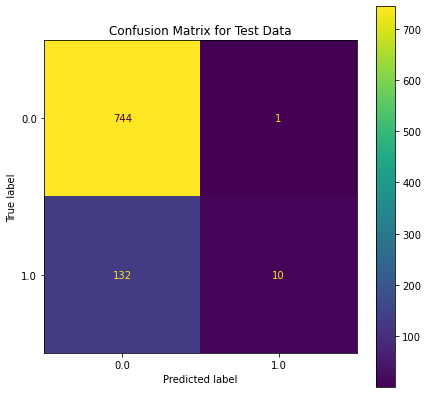

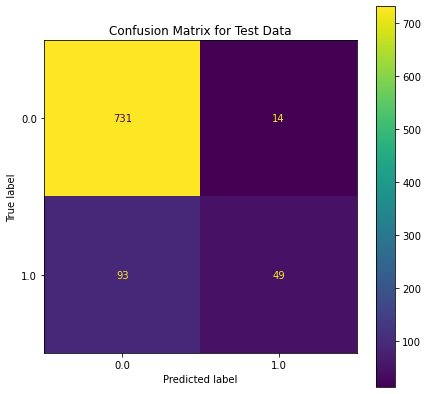

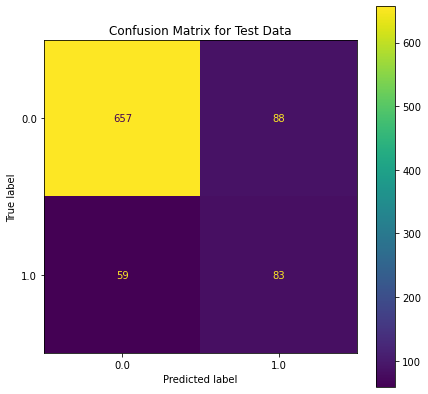

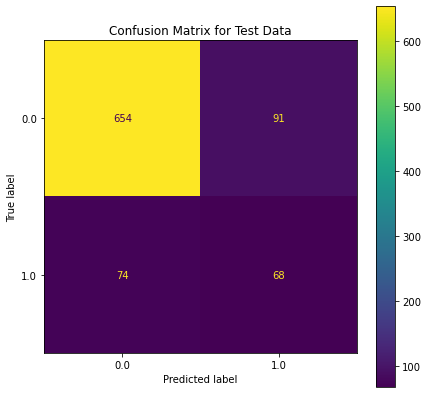

In [299]:
# Class Model object instantiation

#TF-IDF and Count
lr_TF = Model("Logistic TF-IDF", lr_tfidf, tfidf, X_train_transformed, X_test_transformed, y_train, y_test)
lr_C = Model("Logistic Count-Vect", lr_count, count_v, Xt_count, X_test_count, y_train, y_test)

# With Smote resampling
lr_TF_S = Model("Logistic TF-IDF Smote", lr_tfidf_smote, tfidf, X_res_tfidf, X_test_transformed, y_res, y_test)
lr_C_S = Model("Logistic Count Smote", lr_count_smote, count_v, X_res_count, X_test_count, y_res_count, y_test)

In [302]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.839910,0.000000,0.000000,0.000000,5.770235,0.500000
1,Naive Bayes 1,0.841413,0.800000,0.014036,0.027535,0.450482,0.839910,0.000000,0.000000,0.000000,0.485984,0.792031
2,MNB Count Vect,0.847051,0.540955,0.334172,0.411992,0.522335,0.865840,0.725490,0.260563,0.383420,0.569251,0.819283
3,RF tfidf,0.839158,0.000000,0.000000,0.000000,0.425232,0.839910,0.000000,0.000000,0.000000,0.423115,0.762378
4,RF count,0.839158,0.000000,0.000000,0.000000,0.425335,0.839910,0.000000,0.000000,0.000000,0.423232,0.746966
5,Ada tfidf,0.852682,0.580502,0.301560,0.395751,0.644153,0.845547,0.528736,0.323944,0.401747,0.651335,0.757397
6,Ada count,0.855314,0.608217,0.306265,0.403826,0.651356,0.855693,0.606061,0.281690,0.384615,0.656700,0.778065
7,X tfidf,0.857946,0.670115,0.245472,0.355644,0.356290,0.866967,0.714286,0.281690,0.404040,0.352597,0.796658
8,X count,0.863960,0.719101,0.261888,0.380519,0.336920,0.864713,0.689655,0.281690,0.400000,0.337870,0.816396
9,Bayes TF-IDF Smote,0.911332,0.860428,0.982094,0.917192,0.310649,0.813980,0.441026,0.605634,0.510386,0.420624,0.836752


# Going to have to modify the color scheme, but the df object is good

In [304]:
# lr_C_S.compare_roc_curve()

# Adding ensemble methods

In [315]:
Model.model_df.sort_values(by=["test_accuracy"], ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
18,Logistic Count-Vect,0.872597,0.751520,0.308399,0.436060,0.323106,0.879369,0.777778,0.345070,0.478049,0.324493,0.835646
15,XGBoost TF-IDF Smote,0.911382,0.958050,0.863969,0.882422,0.248915,0.869222,0.671053,0.359155,0.467890,0.343019,0.812846
7,X tfidf,0.857946,0.670115,0.245472,0.355644,0.356290,0.866967,0.714286,0.281690,0.404040,0.352597,0.796658
2,MNB Count Vect,0.847051,0.540955,0.334172,0.411992,0.522335,0.865840,0.725490,0.260563,0.383420,0.569251,0.819283
8,X count,0.863960,0.719101,0.261888,0.380519,0.336920,0.864713,0.689655,0.281690,0.400000,0.337870,0.816396
6,Ada count,0.855314,0.608217,0.306265,0.403826,0.651356,0.855693,0.606061,0.281690,0.384615,0.656700,0.778065
17,Logistic TF-IDF,0.848926,0.931429,0.065390,0.121330,0.355545,0.850056,0.909091,0.070423,0.130719,0.348905,0.836724
5,Ada tfidf,0.852682,0.580502,0.301560,0.395751,0.644153,0.845547,0.528736,0.323944,0.401747,0.651335,0.757397
10,Bayes Count Smote,0.859867,0.855252,0.862594,0.848226,0.477322,0.843292,0.510638,0.507042,0.508834,0.472048,0.809453
1,Naive Bayes 1,0.841413,0.800000,0.014036,0.027535,0.450482,0.839910,0.000000,0.000000,0.000000,0.485984,0.792031


In [332]:
for num, i in enumerate(Model.model_list):
    print(num, i.name)

0 Dummy
1 Naive Bayes 1
2 MNB Count Vect
3 RF tfidf
4 RF count
5 Ada tfidf
6 Ada count
7 X tfidf
8 X count
9 Bayes TF-IDF Smote
10 Bayes Count Smote
11 R.F. TF-IDF Smote
12 R.F. Count Smote
13 AdaBoost TF-IDF Smote
14 AdaBoost Count Smote
15 XGBoost TF-IDF Smote
16 XGBoost Count Smote
17 Logistic TF-IDF
18 Logistic Count-Vect
19 Logistic TF-IDF Smote
20 Logistic Count Smote


### Top 3 TFIDF SMOTES

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.2min finished
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


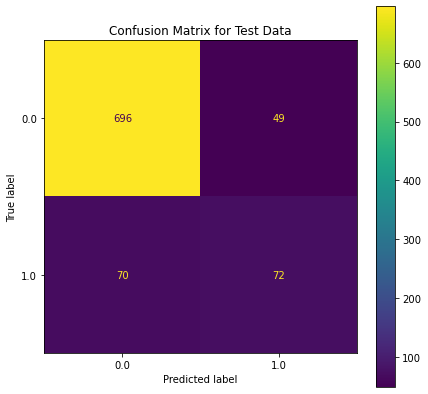

In [341]:
# Cell takes several minutes to run... voting=soft required for class compatability

# TFIDF SMOTE Ensembles
voter_smote_tfidf = VotingClassifier(estimators=[
    ("lr_tfidf_smote", lr_tfidf_smote),
    ("Bayes_tfidf_smote", mnb_smote_tfidf),
    ("XGB_TFIDF_SMOTE", XGB_smote_tfidf),   
], n_jobs=4, verbose=True, voting="soft") 

voter_smote_tfidf.fit(X_res_tfidf, y_res)

voter_smote_tfidf1 = Model("TF-IDF Smote Ensemble", voter_smote_tfidf, tfidf, X_res_tfidf, X_test_transformed, y_res, y_test)

In [342]:
Model.model_df.tail(2)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
20,Logistic Count Smote,0.874206,0.861322,0.884110,0.858288,0.334834,0.81398,0.427673,0.478873,0.451827,0.430466,0.775073
21,TF-IDF Smote Ensemble,0.943813,0.936274,0.953466,0.942487,0.276596,0.86584,0.595041,0.507042,0.547529,0.362877,0.854646


### Top 3 COUNT SMOTES

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.3min finished
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


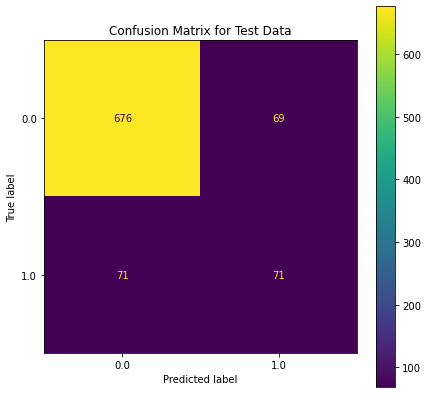

In [352]:
# Cell takes several minutes to run...

# Count-Smote Ensembles
voter_smote_count = VotingClassifier(estimators=[
    ("Bayes_Count_Smote", mnb_smote_count),
    ("XGB_C_S", XGB_smote_count),
    ("LR_C_S", lr_count_smote),
], n_jobs=4, verbose=True, voting="soft")

voter_smote_count.fit(X_res_count, y_res_count)

voter_smote_count1 = Model("Count Smote Ensemble", voter_smote_count, count_v, X_res_count, X_test_count, y_res_count, y_test)

In [358]:
Model.model_df[3:10]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
3,RF tfidf,0.839158,0.000000,0.000000,0.000000,0.425232,0.839910,0.000000,0.000000,0.000000,0.423115,0.762378
4,RF count,0.839158,0.000000,0.000000,0.000000,0.425335,0.839910,0.000000,0.000000,0.000000,0.423232,0.746966
5,Ada tfidf,0.852682,0.580502,0.301560,0.395751,0.644153,0.845547,0.528736,0.323944,0.401747,0.651335,0.757397
6,Ada count,0.855314,0.608217,0.306265,0.403826,0.651356,0.855693,0.606061,0.281690,0.384615,0.656700,0.778065
7,X tfidf,0.857946,0.670115,0.245472,0.355644,0.356290,0.866967,0.714286,0.281690,0.404040,0.352597,0.796658
8,X count,0.863960,0.719101,0.261888,0.380519,0.336920,0.864713,0.689655,0.281690,0.400000,0.337870,0.816396
9,Bayes TF-IDF Smote,0.911332,0.860428,0.982094,0.917192,0.310649,0.813980,0.441026,0.605634,0.510386,0.420624,0.836752


### Top 3 TFIDF Raw

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.5min finished
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


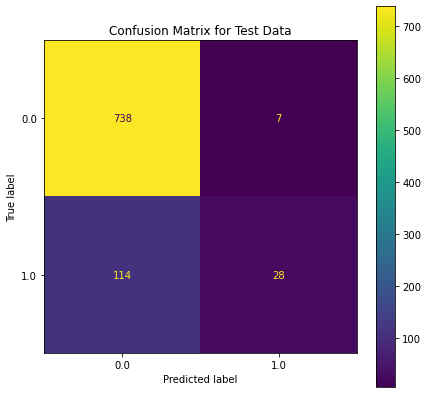

In [363]:
# Cell takes several minutes to run...

# TFIDF Ensembles
voter_tfidf = VotingClassifier(estimators=[
    ('lr_tf', lr_tfidf),
    ('XGB_TF', x_tfidf),
    ('ADA_TF', ada_tfidf),
], n_jobs=4, verbose=True, voting="soft")

voter_tfidf.fit(X_train_transformed, y_train)

V_TFIDF = Model("TFIDF Ensemble", voter_tfidf, tfidf, X_train_transformed, X_test_transformed, y_train, y_test)

In [364]:
Model.model_df.tail()

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
19,Logistic TF-IDF Smote,0.928353,0.897227,0.967776,0.930847,0.340632,0.834273,0.485380,0.584507,0.530351,0.395032,0.848190
20,Logistic Count Smote,0.874206,0.861322,0.884110,0.858288,0.334834,0.813980,0.427673,0.478873,0.451827,0.430466,0.775073
21,TF-IDF Smote Ensemble,0.943813,0.936274,0.953466,0.942487,0.276596,0.865840,0.595041,0.507042,0.547529,0.362877,0.854646
22,Count Smote Ensemble,0.874653,0.864913,0.880525,0.858790,0.334251,0.842165,0.507143,0.500000,0.503546,0.375607,0.804764
23,TFIDF Ensemble,0.858324,0.782636,0.168372,0.275297,0.402724,0.863585,0.800000,0.197183,0.316384,0.399639,0.817402


In [367]:
type(XG)

sklearn.ensemble._weight_boosting.AdaBoostClassifier

### Top 3 Count Raw

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.5min finished
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


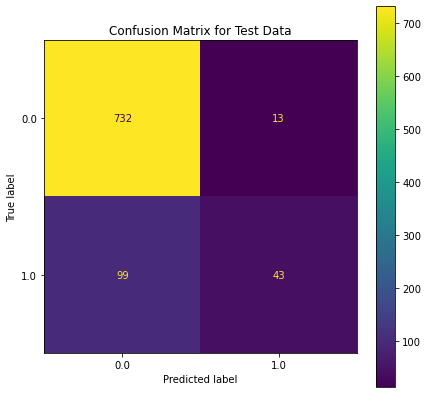

In [368]:
# Cell takes several minutes to run...

# Count Vect Ensembles
voter_count = VotingClassifier(estimators=[
    ('LR_COUNT', lr_count),
    ("XGB_Count", x_count),
    ("ADA_COUNT", ada_count),
], n_jobs=4, verbose=True, voting="soft")

voter_count.fit(Xt_count, y_train)

C_TFIDF = Model("Count-V Ensemble", voter_count, count_v, Xt_count, X_test_count, y_train, y_test)

In [369]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.839910,0.000000,0.000000,0.000000,5.770235,0.500000
1,Naive Bayes 1,0.841413,0.800000,0.014036,0.027535,0.450482,0.839910,0.000000,0.000000,0.000000,0.485984,0.792031
2,MNB Count Vect,0.847051,0.540955,0.334172,0.411992,0.522335,0.865840,0.725490,0.260563,0.383420,0.569251,0.819283
3,RF tfidf,0.839158,0.000000,0.000000,0.000000,0.425232,0.839910,0.000000,0.000000,0.000000,0.423115,0.762378
4,RF count,0.839158,0.000000,0.000000,0.000000,0.425335,0.839910,0.000000,0.000000,0.000000,0.423232,0.746966
5,Ada tfidf,0.852682,0.580502,0.301560,0.395751,0.644153,0.845547,0.528736,0.323944,0.401747,0.651335,0.757397
6,Ada count,0.855314,0.608217,0.306265,0.403826,0.651356,0.855693,0.606061,0.281690,0.384615,0.656700,0.778065
7,X tfidf,0.857946,0.670115,0.245472,0.355644,0.356290,0.866967,0.714286,0.281690,0.404040,0.352597,0.796658
8,X count,0.863960,0.719101,0.261888,0.380519,0.336920,0.864713,0.689655,0.281690,0.400000,0.337870,0.816396
9,Bayes TF-IDF Smote,0.911332,0.860428,0.982094,0.917192,0.310649,0.813980,0.441026,0.605634,0.510386,0.420624,0.836752


# Observations

After testing 25 models, it seems that the TF-IDF Smote Ensemble and Count_V Ensemble have some promise. The TF-IDF Ensemble consists of:
- Logistic Regression 
- Multinomial Bayes
- XGBoost

The Count Vectorizer Ensemble Consists of:
- Logistic Regression
- XGBoost
- AdaBoost

The next task would be to reduce the overfitting that we see present in the TF-IDF Smote ensemble model. The Count Vectorized Ensemble is not overfit by contrast. I will try to compare the results of tuning these ensembles to other standalone models. That being said, the TF-IDF Smote ensemble still falls outside of the top 10 best test accuracy performers, whereas the Count Vectorized Ensemble is the 2nd best. 

### A Look at the top 5 models by test accuracy

In [421]:
Model.model_df.sort_values(by="test_accuracy", ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
18,Logistic Count-Vect,0.872597,0.751520,0.308399,0.436060,0.323106,0.879369,0.777778,0.345070,0.478049,0.324493,0.835646
24,Count-V Ensemble,0.868846,0.773882,0.268810,0.396528,0.382799,0.873732,0.767857,0.302817,0.434343,0.383464,0.829275
15,XGBoost TF-IDF Smote,0.911382,0.958050,0.863969,0.882422,0.248915,0.869222,0.671053,0.359155,0.467890,0.343019,0.812846
7,X tfidf,0.857946,0.670115,0.245472,0.355644,0.356290,0.866967,0.714286,0.281690,0.404040,0.352597,0.796658
2,MNB Count Vect,0.847051,0.540955,0.334172,0.411992,0.522335,0.865840,0.725490,0.260563,0.383420,0.569251,0.819283


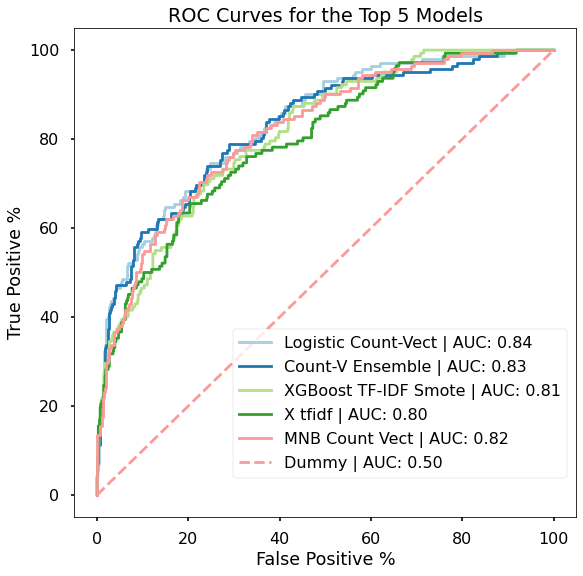

In [420]:
# Plotting the top 5 Models by accuracy against the dummy model
plt.style.use('seaborn-poster')
# List of custom class model objects
top_models = [lr_C, C_TFIDF, XGB_S_T, x1, mnb_count1]
color = sns.color_palette("Paired")
fig, ax = plt.subplots(figsize=(9,9))
for num, i in enumerate(top_models):
    y_hat_hd = i.y_pred_proba[:, 1]
    tpr, fpr, _ = roc_curve(i.y_test, y_hat_hd)
    ax.plot(tpr, fpr, color=color[num], label=f"{i.name} | AUC: {i.auc:.2f}")
ax.legend()
ax.set_yticks([0, .2, .4, .6, .8, 1])
ax.set_yticklabels([0, 20, 40, 60, 80, 100])
ax.set_xticks([0, .2, .4, .6, .8, 1])
ax.set_xticklabels([0, 20, 40, 60, 80, 100])
ax.set_ylabel("True Positive %")
ax.set_xlabel("False Positive %")
ax.set_title("ROC Curves for the Top 5 Models")

y_hat_hd = dummy_0.y_pred_proba[:, 1]
tpr, fpr, _ = roc_curve(dummy_0.y_test, y_hat_hd)
ax.plot(tpr, fpr, color=color[num], label=f"{dummy_0.name} | AUC: {dummy_0.auc:.2f}", linestyle="--")

ax.legend(bbox_to_anchor=(.3,.4));

# Top 5 Iterations

I will perform some grid searches on these baseline models and see if certain hyper-parameters perform much better than their baseline forms. 

In [432]:
type(mnb_count)   # [lr_count, voter_count, XGB_smote_tfidf, x_tfidf, mnb_count]

sklearn.naive_bayes.MultinomialNB

# Iterations of Logistic Regression with Count Vectorization

In [434]:
for i in lr_count.get_params().keys():
    print(i)

C
class_weight
dual
fit_intercept
intercept_scaling
l1_ratio
max_iter
multi_class
n_jobs
penalty
random_state
solver
tol
verbose
warm_start


In [ ]:
LogisticRegression()

In [439]:
params = {"C": [1, .5, .1, .01],
         "max_iter": [100, 150, 200],
         "solver": ["lbfgs", "liblinear", "newton-cholesky"],
         "penalty": ["l2", "l1"] 
         }

In [440]:
# Takes several minutes to run

from sklearn.model_selection import GridSearchCV

grid_lr_count = GridSearchCV(lr_count, param_grid=params, n_jobs=4, verbose=2)

grid_lr_count.fit(Xt_count, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.

GridSearchCV(estimator=LogisticRegression(n_jobs=-4, random_state=42), n_jobs=4,
             param_grid={'C': [1, 0.5, 0.1, 0.01], 'max_iter': [100, 150, 200],
                         'penalty': ['l2', 'l1'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cholesky']},
             verbose=2)

In [443]:
grid_lr_count.best_params_

{'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

In [444]:
lr_count.solver

'lbfgs'

The only difference between the default Logistic Regression model and the grid searched hyper parameters is the solver. Lets compare the score of the best estimator and our default model:

In [445]:
print(f"ORIGINAL: {lr_count.score(X_test_count, y_test)} | GRID: {grid_lr_count.best_estimator_.score(X_test_count, y_test)}")

ORIGINAL: 0.8793686583990981 | GRID: 0.8816234498308907


As you can see, there is a slight improvement of our model's performance on test accuracy, and so, we will add it to the class list.

# BEST MODEL INSTANTIATION

# BEST MODEL INSTANTIATION

# BEST MODEL INSTANTIATION

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.1s finished


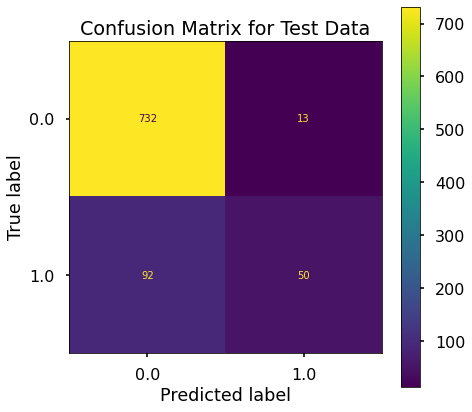

In [447]:
LR_count_grid = Model("Grid LR Count_V", grid_lr_count.best_estimator_, count_v, Xt_count, X_test_count, y_train, y_test)

In [546]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

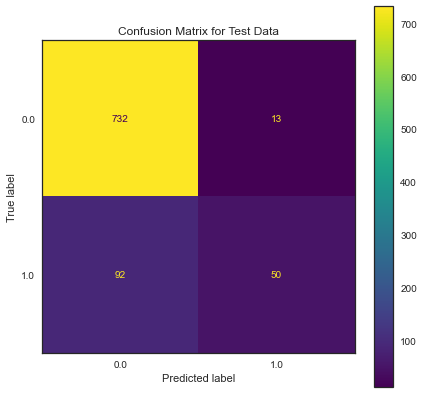

In [553]:
plt.style.use("seaborn-white")
LR_count_grid.confusion_matrix();

In [449]:
Model.model_df.sort_values(by="test_accuracy", ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
25,Grid LR Count_V,0.872597,0.746580,0.313051,0.440062,0.322835,0.881623,0.793651,0.352113,0.487805,0.324437,0.835646
18,Logistic Count-Vect,0.872597,0.751520,0.308399,0.436060,0.323106,0.879369,0.777778,0.345070,0.478049,0.324493,0.835646
24,Count-V Ensemble,0.868846,0.773882,0.268810,0.396528,0.382799,0.873732,0.767857,0.302817,0.434343,0.383464,0.829275
15,XGBoost TF-IDF Smote,0.911382,0.958050,0.863969,0.882422,0.248915,0.869222,0.671053,0.359155,0.467890,0.343019,0.812846
7,X tfidf,0.857946,0.670115,0.245472,0.355644,0.356290,0.866967,0.714286,0.281690,0.404040,0.352597,0.796658


### New # 1

This model is a slight improvment on what was already one of the best performing models. New # 1

# Count Vec Ensemble Model Iterations

### Come back to this after other models are grid searched.
Ideally, I will use the grid search optimized models to compose the same ensemble method after performing those grid searches.

In [452]:
for i in voter_count.get_params().keys():
    print(i)

estimators
flatten_transform
n_jobs
verbose
voting
weights
LR_COUNT
XGB_Count
ADA_COUNT
LR_COUNT__C
LR_COUNT__class_weight
LR_COUNT__dual
LR_COUNT__fit_intercept
LR_COUNT__intercept_scaling
LR_COUNT__l1_ratio
LR_COUNT__max_iter
LR_COUNT__multi_class
LR_COUNT__n_jobs
LR_COUNT__penalty
LR_COUNT__random_state
LR_COUNT__solver
LR_COUNT__tol
LR_COUNT__verbose
LR_COUNT__warm_start
XGB_Count__objective
XGB_Count__base_score
XGB_Count__booster
XGB_Count__colsample_bylevel
XGB_Count__colsample_bynode
XGB_Count__colsample_bytree
XGB_Count__gamma
XGB_Count__gpu_id
XGB_Count__importance_type
XGB_Count__interaction_constraints
XGB_Count__learning_rate
XGB_Count__max_delta_step
XGB_Count__max_depth
XGB_Count__min_child_weight
XGB_Count__missing
XGB_Count__monotone_constraints
XGB_Count__n_estimators
XGB_Count__n_jobs
XGB_Count__num_parallel_tree
XGB_Count__random_state
XGB_Count__reg_alpha
XGB_Count__reg_lambda
XGB_Count__scale_pos_weight
XGB_Count__subsample
XGB_Count__tree_method
XGB_Count__valida

# XGBoost TF-IDF Smote Iterations

In [456]:
for i in XGB_smote_tfidf.get_params().keys():
    print(i)

objective
base_score
booster
colsample_bylevel
colsample_bynode
colsample_bytree
gamma
gpu_id
importance_type
interaction_constraints
learning_rate
max_delta_step
max_depth
min_child_weight
missing
monotone_constraints
n_estimators
n_jobs
num_parallel_tree
random_state
reg_alpha
reg_lambda
scale_pos_weight
subsample
tree_method
validate_parameters
verbosity


In [ ]:
# Example params to search for in XGBoost
param_grid = {
    'silent': [1],
    'max_depth': [4,5,6,7],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    'n_estimators': [100]}

In [469]:
# Creating a new instance of the XGBClassifier, with n_jobs stated explicitly, otherwise same parameters....
xgb_w_smote_tfidf = XGBClassifier(n_jobs=-1, random_state=42, objective="binary:logistic")

# replace "XGB_smote_tfidf" with "xgb_w_smote_tfidf" in the morning

# This cell took too long when i ran it without specifying the n_jobs within the XGBoost Classifier

The massive amount of time required to run these searches is a discouraging factor, especially considering that the overall improvement of the model tends to be rather low.

In [472]:
# This cell takes >1 hour to run on my computer

# Trying RandomizedSearchCV instead of grid search
from sklearn.model_selection import RandomizedSearchCV

params = {"n_estimators": [100, 200, 300],
         "max_depth": [6, 5, 4],
         "booster": ["gbtree", "gblinear", "dart"],
         "reg_lambda": [0.1, 1.0, 5.0, 10.0, 25.0] 
         }

grid_xg_tfidf_smote = RandomizedSearchCV(xgb_w_smote_tfidf, param_distributions=params, n_jobs=-1, verbose=3) # try increasing verb

grid_xg_tfidf_smote.fit(X_res_tfidf, y_res)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=42, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                           verbosity=None),
                   n_jobs=-1,
                   param_distributions={'booster': ['gbtree', 'gblinear',
                                                    'dart'],
                                        'max_depth': [6, 5, 4],
                                        'n_estimators': [100, 200, 300],
                                        'reg_lambda': [0.1, 1.0, 5.0, 10.0,
                                                       25.0]},
                   verbose=3)

In [473]:
grid_xg_tfidf_smote.best_params_

{'reg_lambda': 0.1, 'n_estimators': 100, 'max_depth': 4, 'booster': 'dart'}

In [478]:
concat_df["tweet_text"][0]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

# Reminder of Variables That Have Been Created:
- X_train_transformed, X_test_transformed - both TF-IDF vectorizations, "tfidf" transformer
- Xt_count, X_test_count - both Count Vectorizer transformations, "count_v" transformer
- y_train/y_test still totally valid

In [489]:
grid_xg_tfidf_smote.best_estimator_.score(X_test_transformed, y_test)

0.8523111612175873

### Poor performance out of the final model from the RandomSearchCV

In [490]:
# Final Top 5 
Model.model_df.sort_values(by="test_accuracy", ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
25,Grid LR Count_V,0.872597,0.746580,0.313051,0.440062,0.322835,0.881623,0.793651,0.352113,0.487805,0.324437,0.835646
18,Logistic Count-Vect,0.872597,0.751520,0.308399,0.436060,0.323106,0.879369,0.777778,0.345070,0.478049,0.324493,0.835646
24,Count-V Ensemble,0.868846,0.773882,0.268810,0.396528,0.382799,0.873732,0.767857,0.302817,0.434343,0.383464,0.829275
15,XGBoost TF-IDF Smote,0.911382,0.958050,0.863969,0.882422,0.248915,0.869222,0.671053,0.359155,0.467890,0.343019,0.812846
7,X tfidf,0.857946,0.670115,0.245472,0.355644,0.356290,0.866967,0.714286,0.281690,0.404040,0.352597,0.796658


In [493]:
type(LR_count_grid)

__main__.Model

### Plot the ROC curves for the top 5 models now that a best model has been determined

In [496]:
x1.name = "XGBoost w TF-IDF"

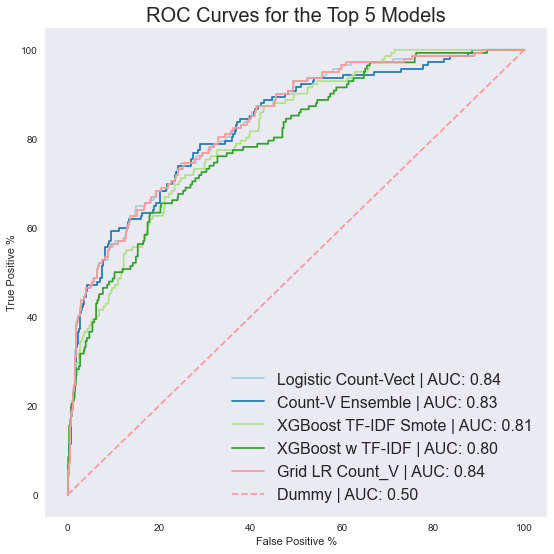

In [537]:
# Plotting the top 5 Models by accuracy against the dummy model
plt.style.use('seaborn')
# List of custom class model objects
top_models = [lr_C, C_TFIDF, XGB_S_T, x1, LR_count_grid]
color = sns.color_palette("Paired")
fig, ax = plt.subplots(figsize=(9,9))
for num, i in enumerate(top_models):
    y_hat_hd = i.y_pred_proba[:, 1]
    tpr, fpr, _ = roc_curve(i.y_test, y_hat_hd)
    ax.plot(tpr, fpr, color=color[num], label=f"{i.name} | AUC: {i.auc:.2f}")
ax.legend()
ax.set_yticks([0, .2, .4, .6, .8, 1])
ax.set_yticklabels([0, 20, 40, 60, 80, 100])
ax.set_xticks([0, .2, .4, .6, .8, 1])
ax.set_xticklabels([0, 20, 40, 60, 80, 100])
ax.set_ylabel("True Positive %")
ax.set_xlabel("False Positive %")
ax.set_title("ROC Curves for the Top 5 Models", fontsize=20)

y_hat_hd = dummy_0.y_pred_proba[:, 1]
tpr, fpr, _ = roc_curve(dummy_0.y_test, y_hat_hd)
ax.plot(tpr, fpr, color=color[num], label=f"{dummy_0.name} | AUC: {dummy_0.auc:.2f}", linestyle="--")
plt.grid(False)
ax.legend(bbox_to_anchor=(.5,.3))
plt.legend(fontsize=16);

# Final Thoughts

After some deliberation, I determined that given my computer's computational power and my experience with the model improvement provided through grid-search tuning, that the Grid Searched Version of my Logistic Regression model with Count Vectorization was quite likely to be the best classifier. The model is near the top of every statistical measure, and given we have decided that test accuracy is the goal, this is the best model for test accuracy. 

### Export Model DF

In [539]:
Model.model_df.to_csv("/Users/samalainabayeva/Desktop/Water Project CSVs/binary_model_df.csv")

### Sanity Check

In [541]:
pd.read_csv("/Users/samalainabayeva/Desktop/Water Project CSVs/binary_model_df.csv", index_col=0)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.839910,0.000000,0.000000,0.000000,5.770235,0.500000
1,Naive Bayes 1,0.841413,0.800000,0.014036,0.027535,0.450482,0.839910,0.000000,0.000000,0.000000,0.485984,0.792031
2,MNB Count Vect,0.847051,0.540955,0.334172,0.411992,0.522335,0.865840,0.725490,0.260563,0.383420,0.569251,0.819283
3,RF tfidf,0.839158,0.000000,0.000000,0.000000,0.425232,0.839910,0.000000,0.000000,0.000000,0.423115,0.762378
4,RF count,0.839158,0.000000,0.000000,0.000000,0.425335,0.839910,0.000000,0.000000,0.000000,0.423232,0.746966
...,...,...,...,...,...,...,...,...,...,...,...,...
21,TF-IDF Smote Ensemble,0.943813,0.936274,0.953466,0.942487,0.276596,0.865840,0.595041,0.507042,0.547529,0.362877,0.854646
22,Count Smote Ensemble,0.874653,0.864913,0.880525,0.858790,0.334251,0.842165,0.507143,0.500000,0.503546,0.375607,0.804764
23,TFIDF Ensemble,0.858324,0.782636,0.168372,0.275297,0.402724,0.863585,0.800000,0.197183,0.316384,0.399639,0.817402
24,Count-V Ensemble,0.868846,0.773882,0.268810,0.396528,0.382799,0.873732,0.767857,0.302817,0.434343,0.383464,0.829275
